In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")






In [31]:
# chargement  données
df = pd.read_csv("gym_members_exercise_tracking.csv")

# aperçu 
print(df.head())

# résumé statistique 
print(df.describe(include='all').transpose())


   Age  Gender  Weight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM   
0   56    Male         88.3        1.71      180      157           60  \
1   46  Female         74.9        1.53      179      151           66   
2   32  Female         68.1        1.66      167      122           54   
3   25    Male         53.2        1.70      190      164           56   
4   38    Male         46.1        1.79      188      158           68   

   Session_Duration (hours)  Calories_Burned Workout_Type  Fat_Percentage   
0                      1.69           1313.0         Yoga            12.6  \
1                      1.30            883.0         HIIT            33.9   
2                      1.11            677.0       Cardio            33.4   
3                      0.59            532.0     Strength            28.8   
4                      0.64            556.0     Strength            29.2   

   Water_Intake (liters)  Workout_Frequency (days/week)  Experience_Level   
0              

In [32]:
# on convertit les colonnes qualitatives
categorical_cols = [
    'Gender',
    'Workout_Type',
    'Experience_Level',
    'Workout_Frequency (days/week)'
]
for col in categorical_cols:
    df[col] = df[col].astype('category')


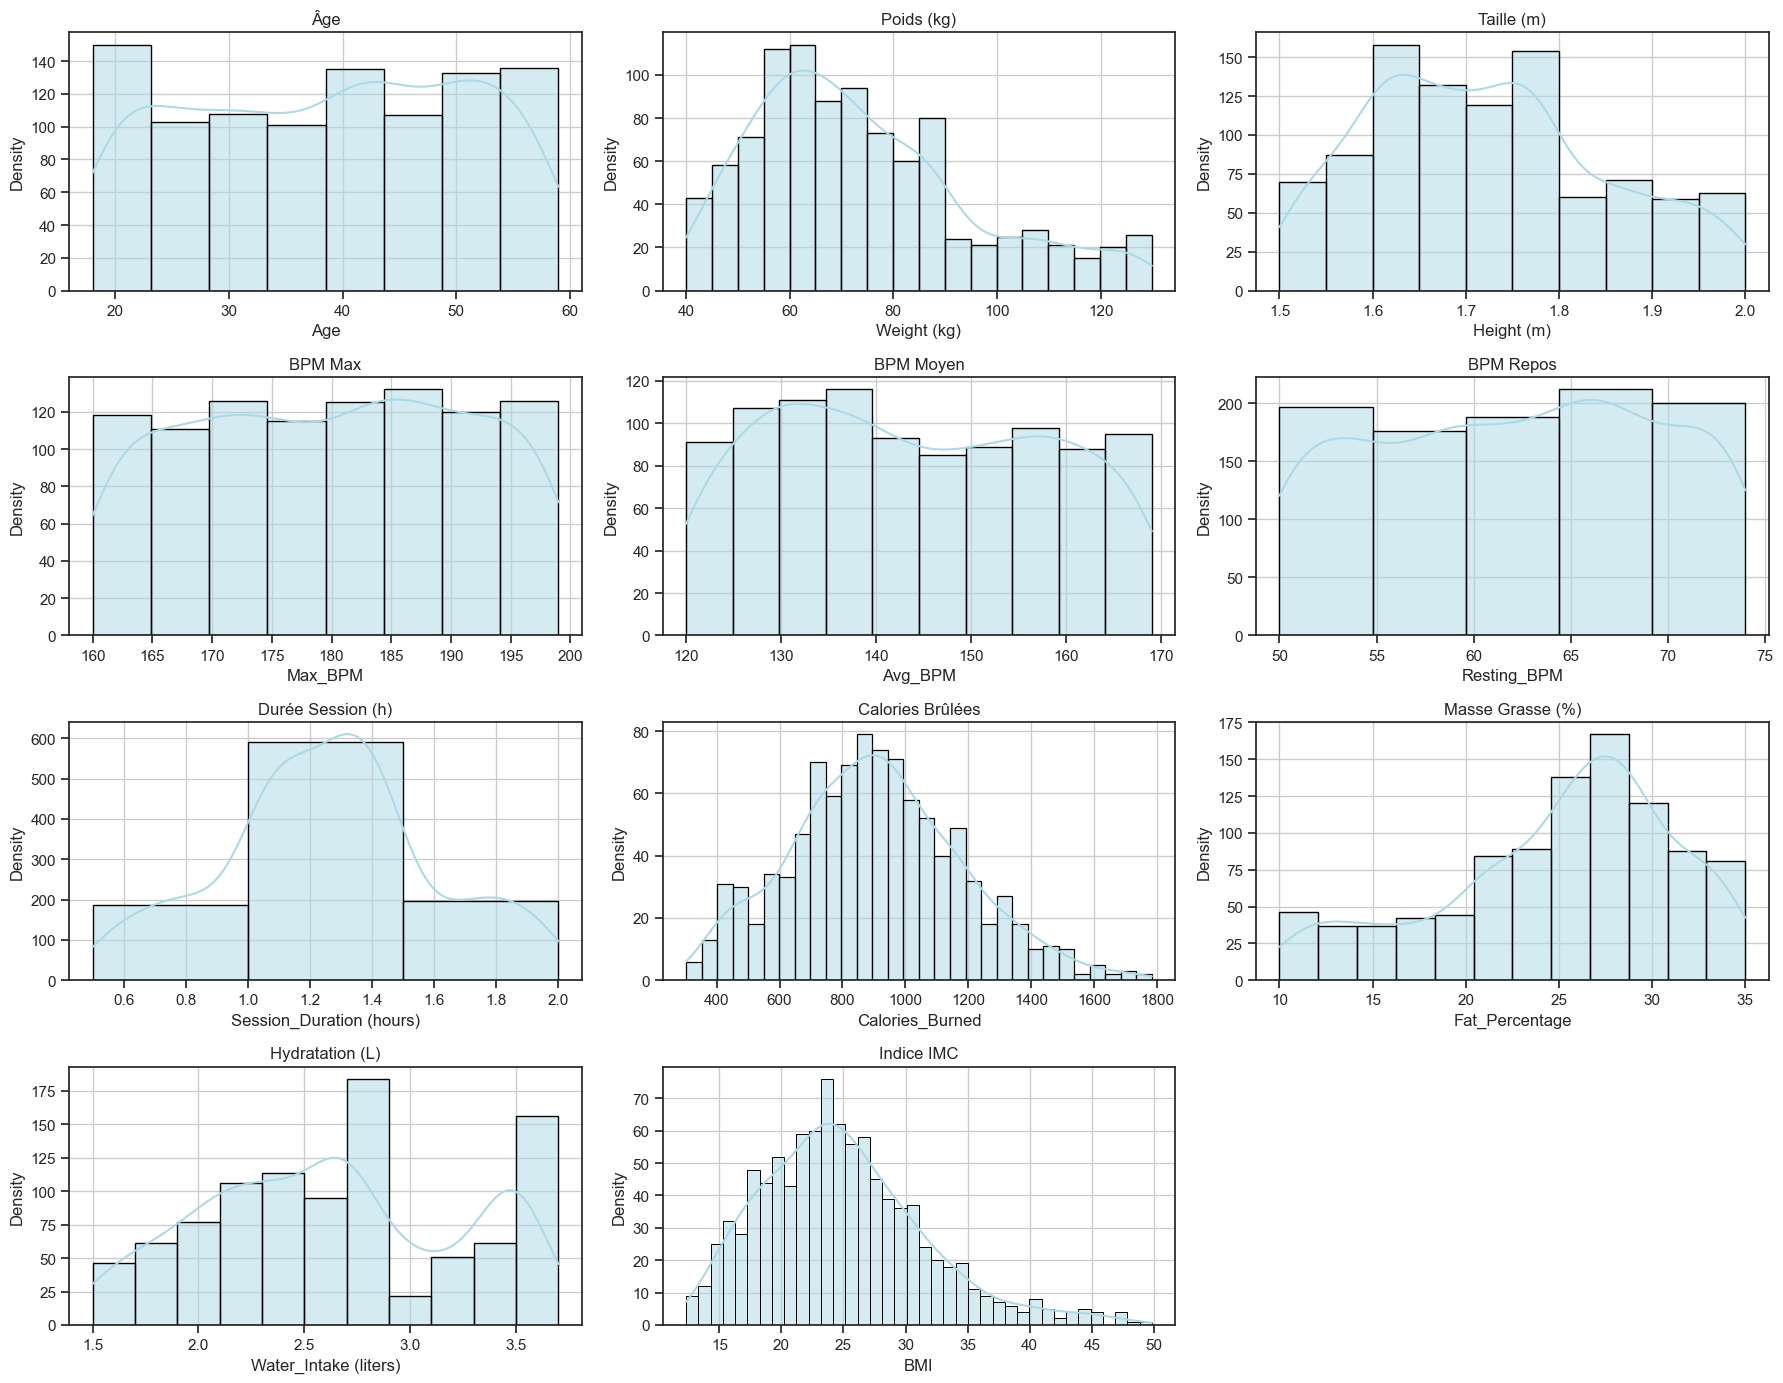

In [33]:
# on trace les histogrammes des variables continues non transformées
# pour détecter les asymétries, valeurs extrêmes etc
plots = [
    ('Age', "Âge", 5),
    ('Weight (kg)', "Poids (kg)", 5),
    ('Height (m)', "Taille (m)", 0.05),
    ('Max_BPM', "BPM Max", 5),
    ('Avg_BPM', "BPM Moyen", 5),
    ('Resting_BPM', "BPM Repos", 5),
    ('Session_Duration (hours)', "Durée Session (h)", 0.5),
    ('Calories_Burned', "Calories Brûlées", 50),
    ('Fat_Percentage', "Masse Grasse (%)", 2),
    ('Water_Intake (liters)', "Hydratation (L)", 0.2),
    ('BMI', "Indice IMC", 1),
]
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(18, 14))
axs = axs.flatten()

for ax, (col, title, bw) in zip(axs, plots):
    sns.histplot(df[col], kde=True, binwidth=bw, ax=ax, color="lightblue", edgecolor="black")
    ax.set_title(title)
    ax.set_xlabel(col)
    ax.set_ylabel("Density")
    ax.grid(True)

for ax in axs[len(plots):]:
    ax.axis("off")

plt.tight_layout()
plt.show()



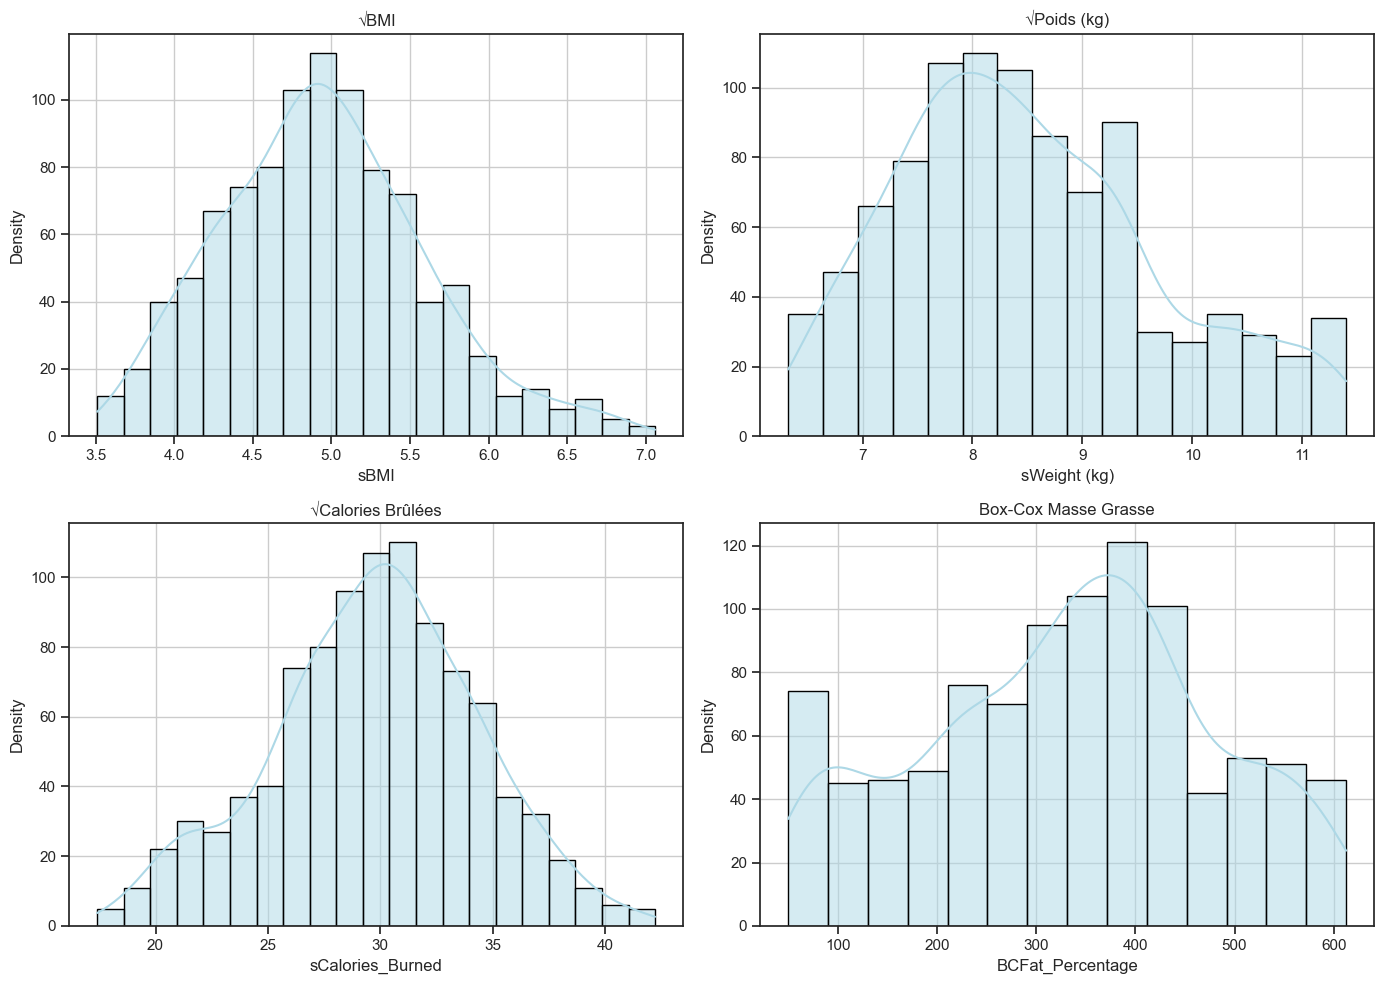

In [34]:
#transformation des variables continues
# on corrige l'asymétrie de certaines variables via racine carrée
# et transformation de type box-cox

df_norm = df.copy()
df_norm['sBMI'] = np.sqrt(df_norm['BMI'])
df_norm['sWeight (kg)'] = np.sqrt(df_norm['Weight (kg)'])
df_norm['sCalories_Burned'] = np.sqrt(df_norm['Calories_Burned'])

lambda_ = 2
df_norm['BCFat_Percentage'] = (df_norm['Fat_Percentage'] ** lambda_) / lambda_

# visualisation des distributions transformées
plots = [
    ('sBMI', '√BMI'),
    ('sWeight (kg)', '√Poids (kg)'),
    ('sCalories_Burned', '√Calories Brûlées'),
    ('BCFat_Percentage', 'Box-Cox Masse Grasse')
]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axs = axs.flatten()

for ax, (col, title) in zip(axs, plots):
    sns.histplot(df_norm[col], kde=True, ax=ax, color="lightblue", edgecolor="black")
    ax.set_title(title)
    ax.set_xlabel(col)
    ax.set_ylabel("Density")
    ax.grid(True)

plt.tight_layout()
plt.show()


In [35]:
# nettoyage et réorganisation du dataset final
columns_to_drop = ['BMI', 'Weight (kg)', 'Calories_Burned', 'Fat_Percentage']
df_norm.drop(columns=columns_to_drop, inplace=True)

ordered_cols = [
    'Age', 'Gender', 'sWeight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM',
    'Resting_BPM', 'Session_Duration (hours)', 'sCalories_Burned', 'Workout_Type',
    'BCFat_Percentage', 'Water_Intake (liters)', 'Workout_Frequency (days/week)',
    'Experience_Level', 'sBMI'
]
df_norm = df_norm[ordered_cols]

print(df_norm.head())

   Age  Gender  sWeight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM   
0   56    Male      9.396808        1.71      180      157           60  \
1   46  Female      8.654479        1.53      179      151           66   
2   32  Female      8.252272        1.66      167      122           54   
3   25    Male      7.293833        1.70      190      164           56   
4   38    Male      6.789698        1.79      188      158           68   

   Session_Duration (hours)  sCalories_Burned Workout_Type  BCFat_Percentage   
0                      1.69         36.235342         Yoga            79.380  \
1                      1.30         29.715316         HIIT           574.605   
2                      1.11         26.019224       Cardio           557.780   
3                      0.59         23.065125     Strength           414.720   
4                      0.64         23.579652     Strength           426.320   

   Water_Intake (liters) Workout_Frequency (days/week) Experience_Le

In [36]:
# séparation variables quanti et quali
quanti_columns = [
    'Age', 'sWeight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM',
    'Resting_BPM', 'Session_Duration (hours)', 'sCalories_Burned',
    'BCFat_Percentage', 'Water_Intake (liters)', 'sBMI'
]

quali_columns = [
    'Gender', 'Workout_Type', 'Workout_Frequency (days/week)', 'Experience_Level'
]


In [37]:
# visualisation croisée des variables quantitatives
# sns.set(style="ticks")
# pairplot = sns.pairplot(df_norm[quanti_columns], corner=True, plot_kws={'alpha': 0.5})
# plt.suptitle("Visualisation croisée des variables quantitatives", y=1.02)
# plt.show()


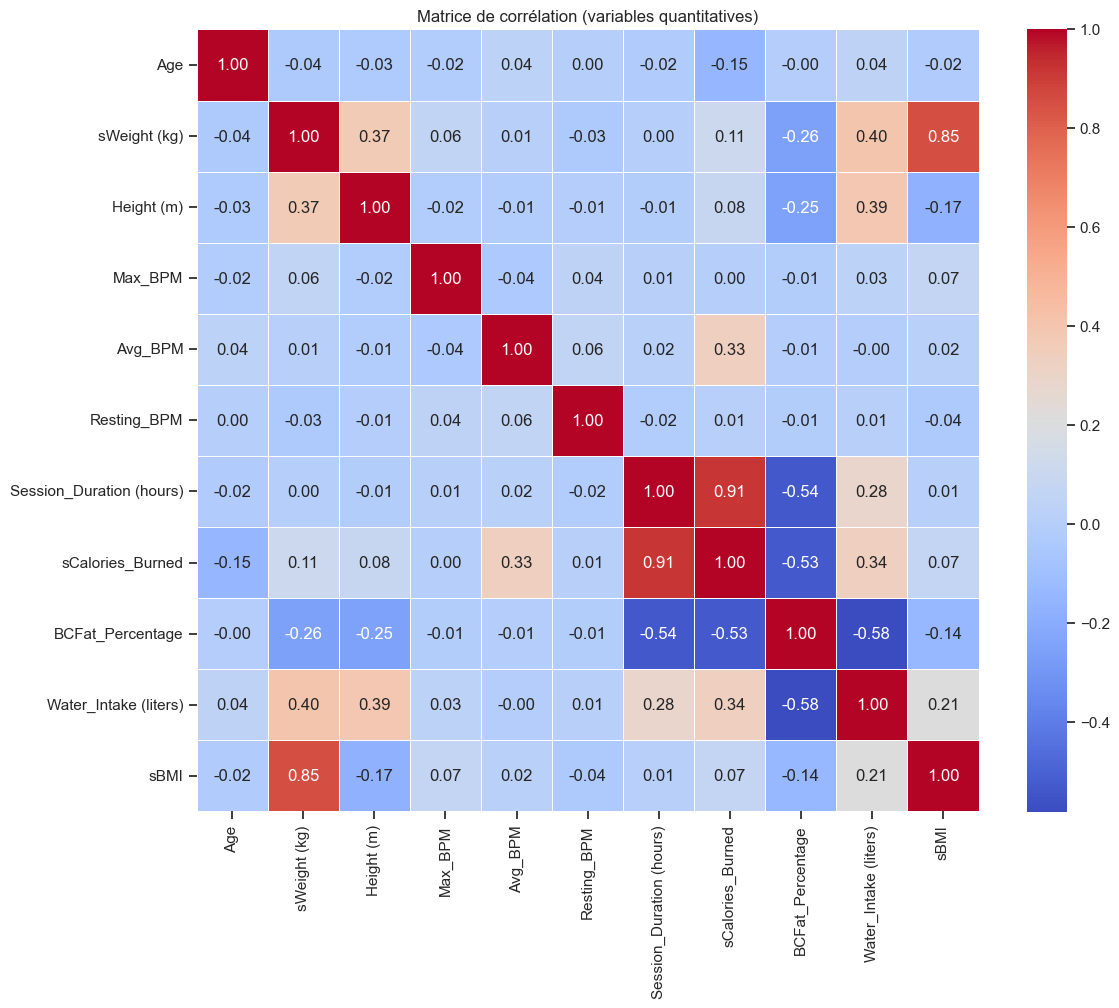

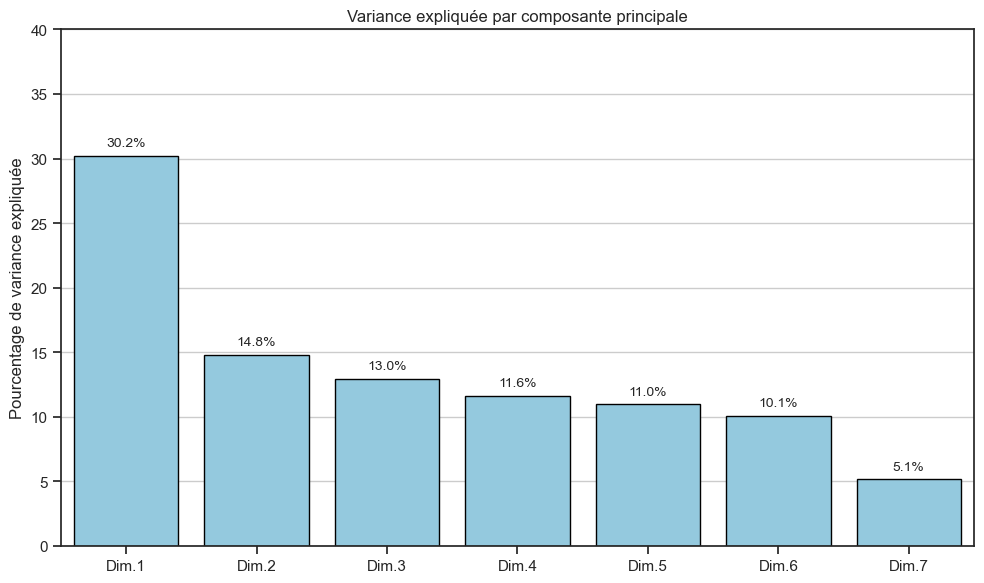

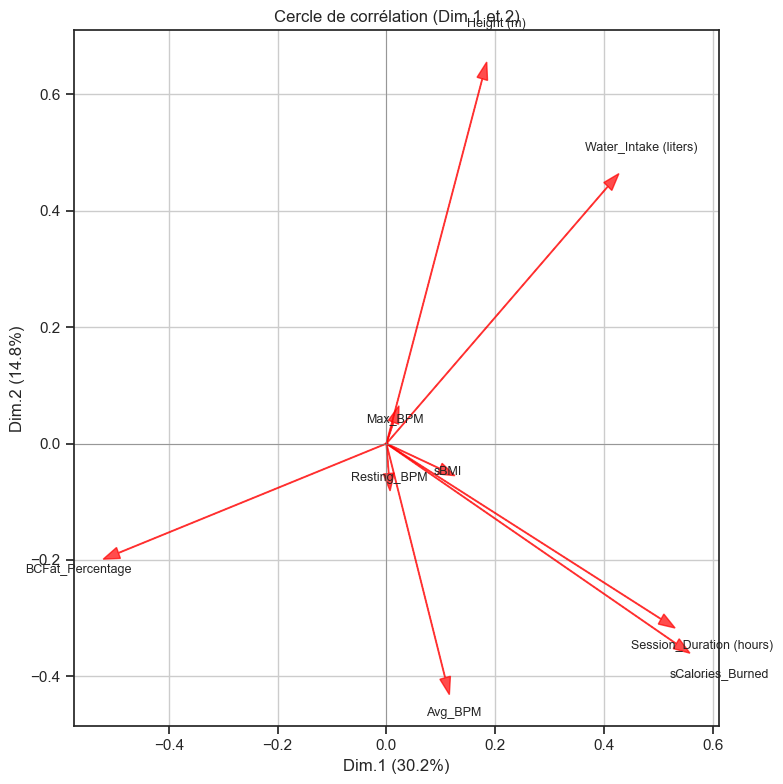

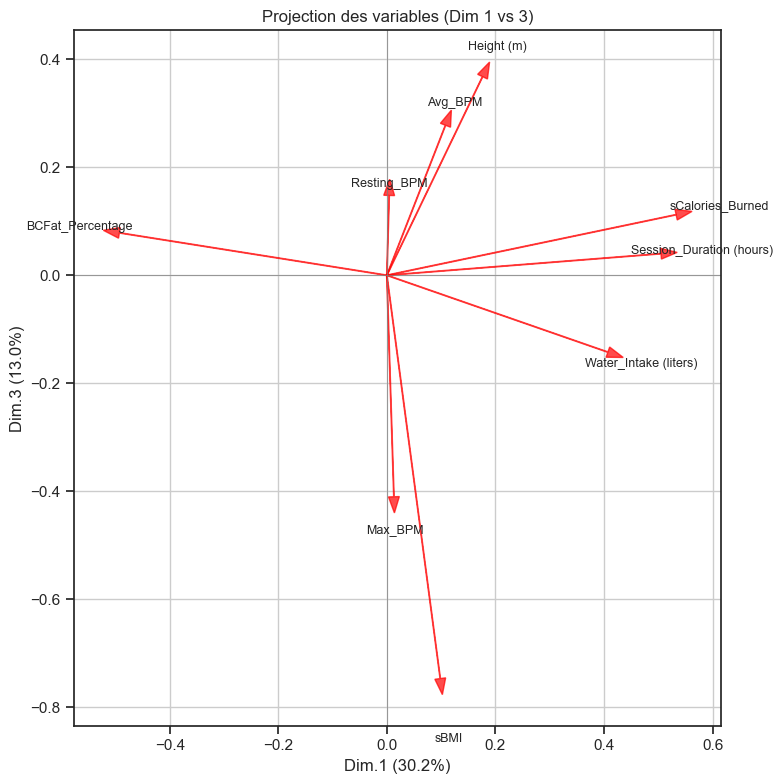

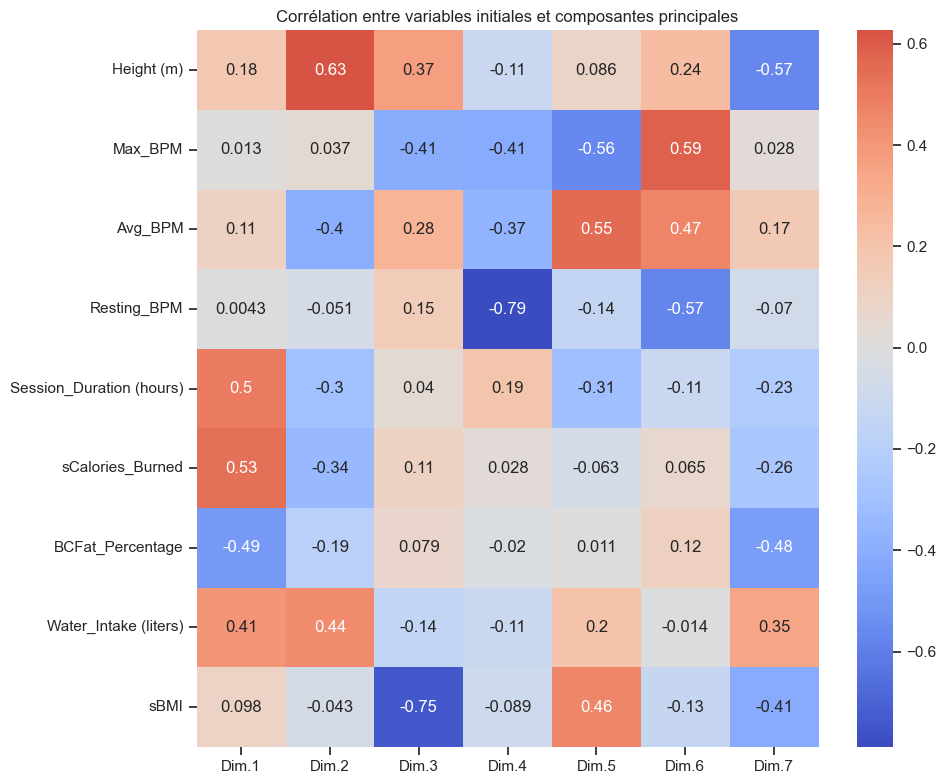

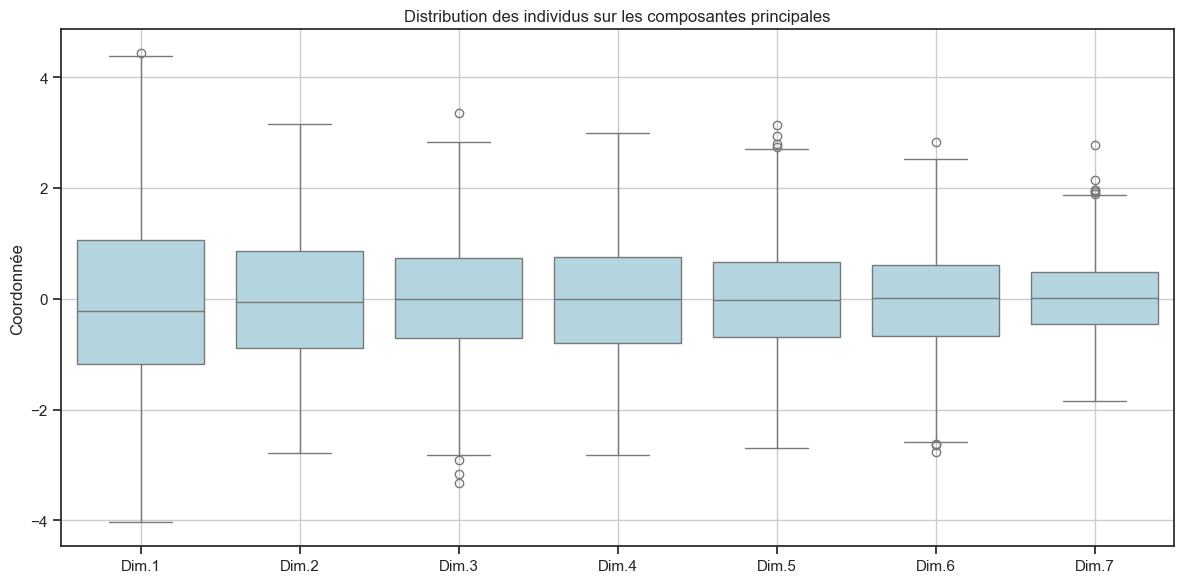

In [38]:
# Sous-ensemble pour l'ACP : variables quantitatives sans Age ni sWeight
quanti_columns_r = [col for col in quanti_columns if col not in ['Age', 'sWeight (kg)']]
X_acp_r = df_norm[quanti_columns_r]

# Standardisation
X_scaled_r = StandardScaler().fit_transform(X_acp_r)

# ACP avec 7 composantes
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_scaled_r)

# DataFrame des composantes principales
pca_df = pd.DataFrame(X_pca, columns=[f"Dim.{i+1}" for i in range(7)])

# Matrice de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(df_norm[quanti_columns].corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Matrice de corrélation (variables quantitatives)")
plt.tight_layout()
plt.show()

# Pourcentage de variance expliquée
explained_var = 100 * pca.explained_variance_ratio_
components = [f"Dim.{i+1}" for i in range(len(explained_var))]

plt.figure(figsize=(10, 6))
bars = sns.barplot(x=components, y=explained_var, color="skyblue", edgecolor="black")
for i, val in enumerate(explained_var):
    bars.text(i, val + 0.5, f"{val:.1f}%", ha='center', va='bottom', fontsize=10)
plt.ylim(0, 40)
plt.ylabel("Pourcentage de variance expliquée")
plt.title("Variance expliquée par composante principale")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Cercle de corrélation (Dim 1 et 2)
loadings_r = pd.DataFrame(pca.components_.T, index=quanti_columns_r, columns=components)
dim_labels = [f"{components[i]} ({explained_var[i]:.1f}%)" for i in range(len(components))]

plt.figure(figsize=(8, 8))
for i in range(loadings_r.shape[0]):
    x = loadings_r.iloc[i, 0]
    y = loadings_r.iloc[i, 1]
    plt.arrow(0, 0, x, y, head_width=0.02, color='red', alpha=0.7)
    plt.text(x * 1.15, y * 1.15, loadings_r.index[i], ha='center', va='center', fontsize=9)
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.xlabel(dim_labels[0])
plt.ylabel(dim_labels[1])
plt.title("Cercle de corrélation (Dim 1 et 2)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Cercle de corrélation : projection des variables (Dim 1 et 3)
plt.figure(figsize=(8, 8))
for i in range(loadings_r.shape[0]):
    x = loadings_r.iloc[i, 0]
    y = loadings_r.iloc[i, 2]
    plt.arrow(0, 0, x, y, head_width=0.02, color='red', alpha=0.7)
    plt.text(x * 1.15, y * 1.15, loadings_r.index[i], ha='center', va='center', fontsize=9)
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.xlabel(dim_labels[0])
plt.ylabel(dim_labels[2])
plt.title("Projection des variables (Dim 1 vs 3)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Heatmap des loadings (corrélations entre variables et composantes)
plt.figure(figsize=(10, 8))
sns.heatmap(loadings_r, annot=True, cmap="coolwarm", center=0)
plt.title("Corrélation entre variables initiales et composantes principales")
plt.tight_layout()
plt.show()

# Distribution des individus par composante (boxplot)
pca_melt = pd.melt(pca_df, var_name="Composante", value_name="Valeur")
plt.figure(figsize=(12, 6))
sns.boxplot(data=pca_melt, x='Composante', y='Valeur', color='lightblue')
plt.xlabel("")
plt.ylabel("Coordonnée")
plt.title("Distribution des individus sur les composantes principales")
plt.grid(True)
plt.tight_layout()
plt.show()


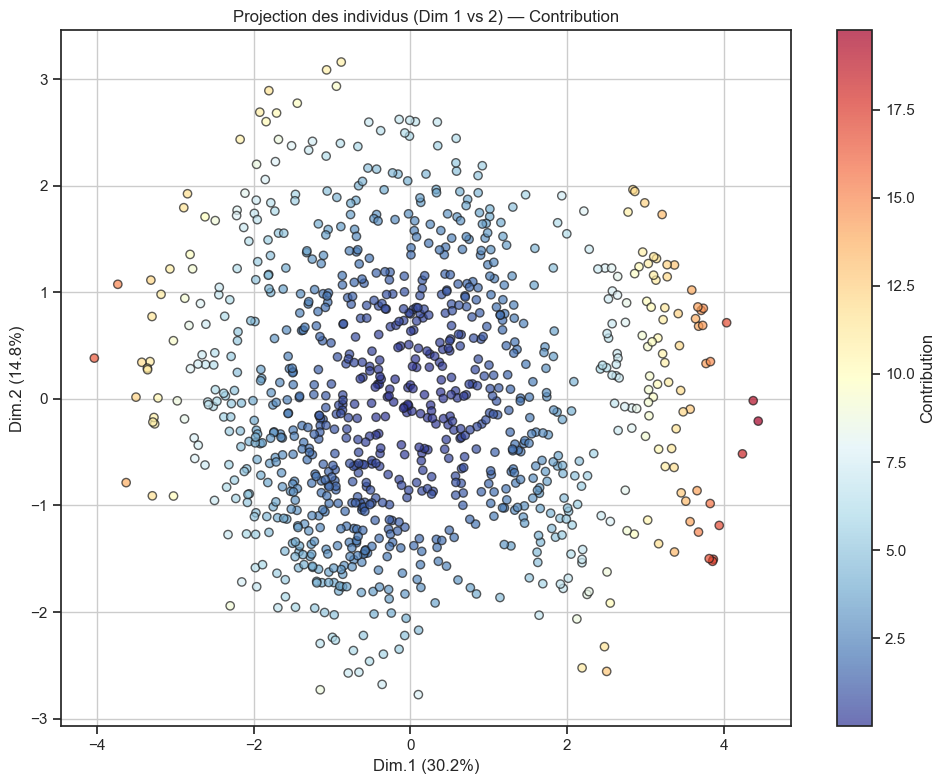

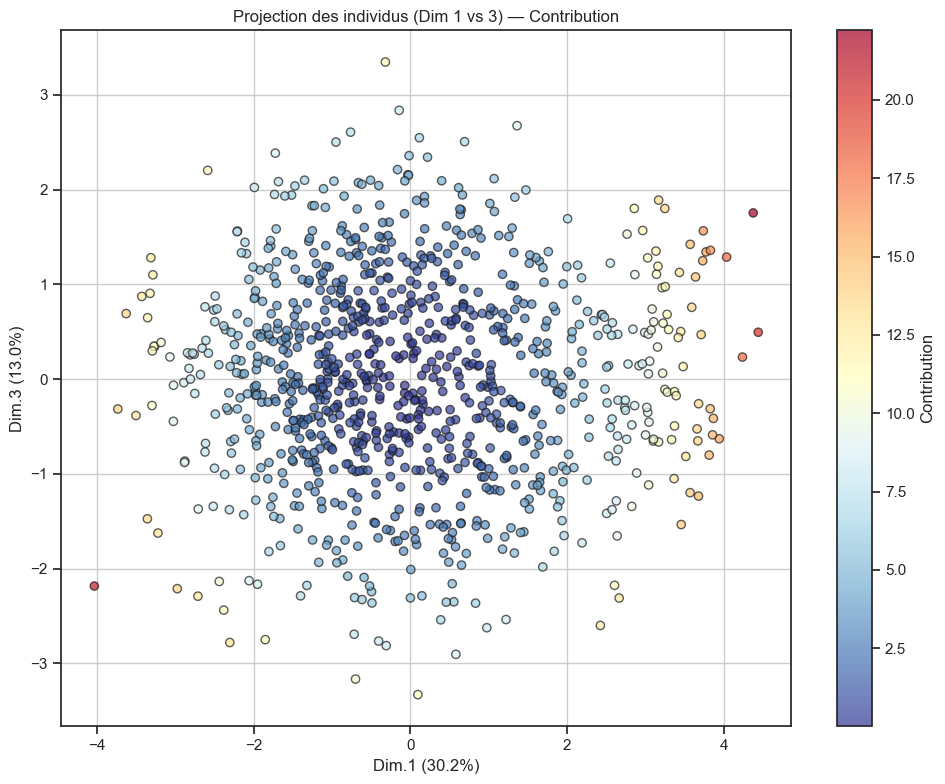

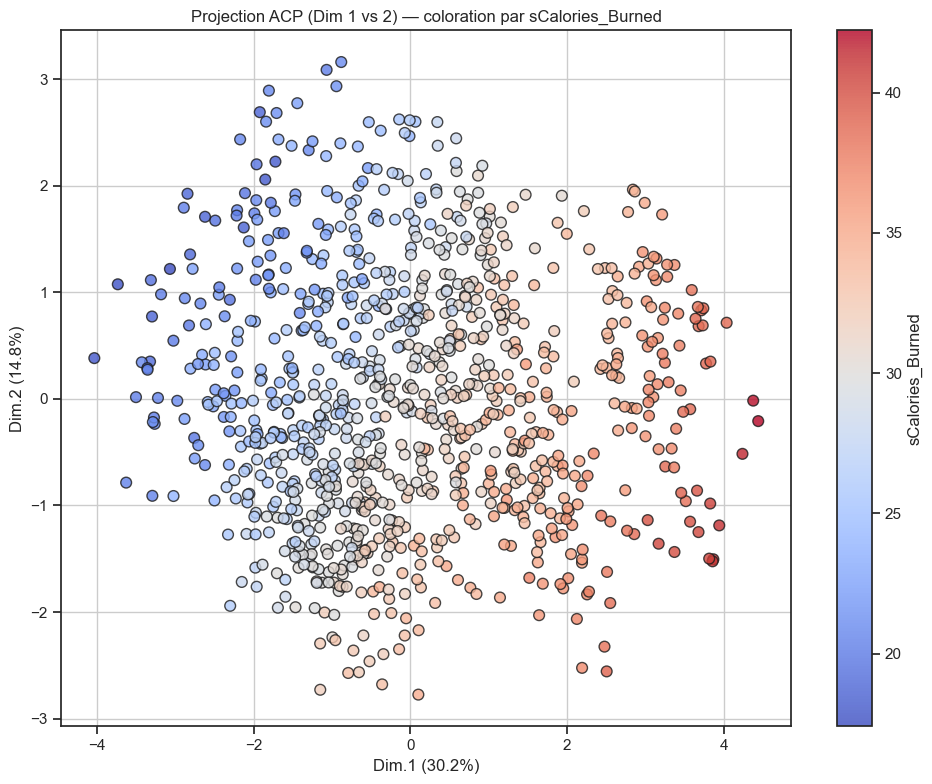

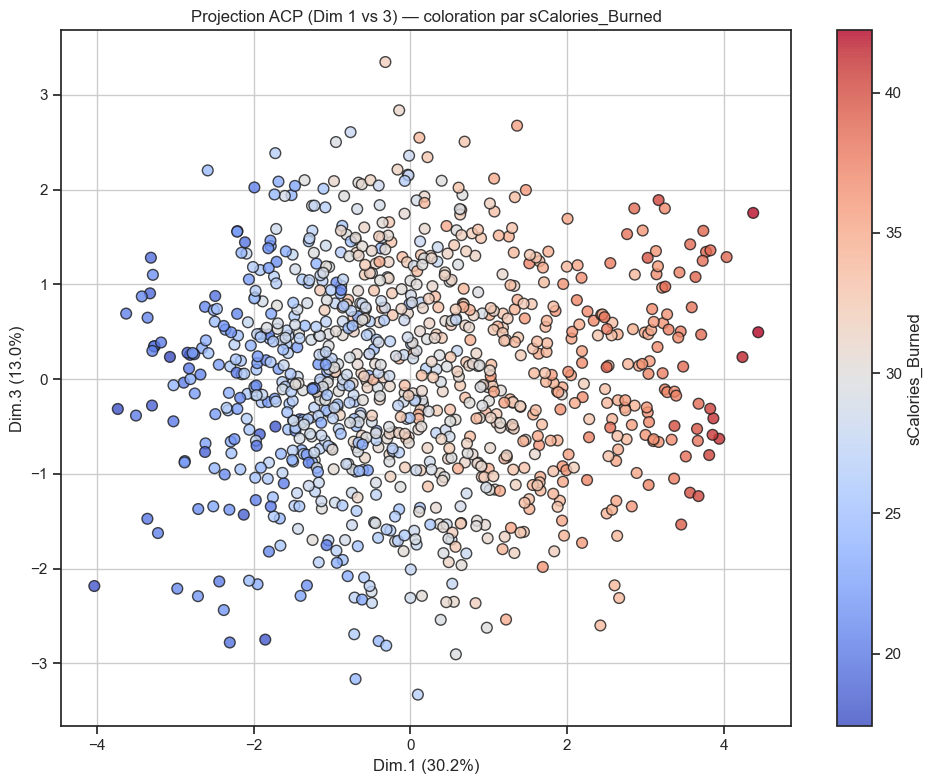

In [39]:
# Contribution dans le plan (Dim 1 et 2)
pca_df['contrib_12'] = np.square(X_pca[:, 0]) + np.square(X_pca[:, 1])

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    pca_df["Dim.1"], pca_df["Dim.2"],
    c=pca_df["contrib_12"], cmap="RdYlBu_r",
    edgecolor='k', alpha=0.7
)
plt.xlabel(dim_labels[0])
plt.ylabel(dim_labels[1])
plt.title("Projection des individus (Dim 1 vs 2) — Contribution")
cbar = plt.colorbar(scatter)
cbar.set_label("Contribution")
plt.grid(True)
plt.tight_layout()
plt.show()

# Contribution dans le plan (Dim 1 et 3)
pca_df['contrib_13'] = np.square(X_pca[:, 0]) + np.square(X_pca[:, 2])

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    pca_df["Dim.1"], pca_df["Dim.3"],
    c=pca_df["contrib_13"], cmap="RdYlBu_r",
    edgecolor='k', alpha=0.7
)
plt.xlabel(dim_labels[0])
plt.ylabel(dim_labels[2])
plt.title("Projection des individus (Dim 1 vs 3) — Contribution")
cbar = plt.colorbar(scatter)
cbar.set_label("Contribution")
plt.grid(True)
plt.tight_layout()
plt.show()

# Coloration par sCalories_Burned (Dim 1 vs 2)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    pca_df["Dim.1"], pca_df["Dim.2"],
    c=df_norm["sCalories_Burned"], cmap="coolwarm",
    edgecolor='k', s=60, alpha=0.8
)
plt.xlabel(dim_labels[0])
plt.ylabel(dim_labels[1])
plt.title("Projection ACP (Dim 1 vs 2) — coloration par sCalories_Burned")
cbar = plt.colorbar(scatter)
cbar.set_label("sCalories_Burned")
plt.grid(True)
plt.tight_layout()
plt.show()

# Coloration par sCalories_Burned (Dim 1 vs 3)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    pca_df["Dim.1"], pca_df["Dim.3"],
    c=df_norm["sCalories_Burned"], cmap="coolwarm",
    edgecolor='k', s=60, alpha=0.8
)
plt.xlabel(dim_labels[0])
plt.ylabel(dim_labels[2])
plt.title("Projection ACP (Dim 1 vs 3) — coloration par sCalories_Burned")
cbar = plt.colorbar(scatter)
cbar.set_label("sCalories_Burned")
plt.grid(True)
plt.tight_layout()
plt.show()


Observations :
- sCalories_Burned et Session_Duration (hours) présentent une forte corrélation positive
- sWeight (kg) et sBMI sont également très corrélés
- BCFat_Percentage est négativement corrélé à Session_Duration (hours)
- BCFat_Percentage est aussi négativement corrélé à Water_Intake (liters)


# 2.2 Prédiction du niveau d'entraînement (classification)

**Fonctions préalables**

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

f1_dico_comp={}

# Fonction : Taux d'erreur à partir d'une matrice de confusion
def erreur_pourcentage(conf_matrix):
    total = np.sum(conf_matrix)
    correct = np.trace(conf_matrix)
    erreurs = total - correct
    pourcentage = (erreurs / total) * 100
    print(f"Pourcentage d'erreur : {pourcentage:.2f} %")
    return pourcentage



# Fonction : Matrice de confusion 

def plot_confusion_matrix(y_true, y_pred, labels=None, title="Matrice de confusion"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    plt.title(title)
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    return cm



# Fonction : ROC par classe 
def plot_roc_curves(y_true, y_probs, class_names, model_name="Modèle"):
    y_bin = label_binarize(y_true, classes=class_names)
    
    plt.figure(figsize=(8, 6))
    colors = plt.cm.Set2(np.linspace(0, 1, len(class_names)))

    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_probs[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i], lw=2, label=f"{class_name} (AUC = {auc_score:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs")
    plt.title(f"Courbes ROC par classe — {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# Fonction : Superposition de courbes ROC 
def plot_superposed_roc_curves(y_true, probs_1, name_1, probs_2, name_2, class_names):
    y_bin = label_binarize(y_true, classes=class_names)
    
    plt.figure(figsize=(10, 8))
    colors1 = plt.cm.Set2(np.linspace(0, 1, len(class_names)))
    colors2 = plt.cm.Dark2(np.linspace(0, 1, len(class_names)))
    
    for i, class_name in enumerate(class_names):
        fpr1, tpr1, _ = roc_curve(y_bin[:, i], probs_1[:, i])
        fpr2, tpr2, _ = roc_curve(y_bin[:, i], probs_2[:, i])
        plt.plot(fpr1, tpr1, color=colors1[i], lw=2, linestyle='-', label=f"{name_1} — {class_name}")
        plt.plot(fpr2, tpr2, color=colors2[i], lw=2, linestyle='--', label=f"{name_2} — {class_name}")
    
    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs")
    plt.title(f"Courbes ROC superposées : {name_1} vs {name_2}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


**Découpage du dataset**

In [41]:

# Colonnes numériques à standardiser
quanti_columns_bis_norm = quanti_columns.copy()

# Colonnes qualitatives à encoder, on exclut notre variable cible
categorical_cols = ['Gender', 'Workout_Type', 'Workout_Frequency (days/week)']

# Séparation des features et de la cible
X = df_norm.drop(columns=["Experience_Level"])
y = df_norm["Experience_Level"]

# Split train/test stratifié
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1234
)

# Reconstruction des DataFrames complets pour inspection ou visualisation
data_exp_norm = X_train_raw.copy()
data_exp_norm["Experience_Level"] = y_train

data_test_norm = X_test_raw.copy()
data_test_norm["Experience_Level"] = y_test

# Standardisation des variables numériques
scaler = StandardScaler()
data_exp_norm[quanti_columns_bis_norm] = scaler.fit_transform(data_exp_norm[quanti_columns_bis_norm])
data_test_norm[quanti_columns_bis_norm] = scaler.transform(data_test_norm[quanti_columns_bis_norm])

# Encodage one-hot 
X_train_encoded = pd.get_dummies(
    data_exp_norm.drop(columns=["Experience_Level"]),
    columns=categorical_cols,
    drop_first=True
)
X_test_encoded = pd.get_dummies(
    data_test_norm.drop(columns=["Experience_Level"]),
    columns=categorical_cols,
    drop_first=True
)

# Harmonisation des colonnes entre train et test
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# 2.2.1 Régression multinomiale

**Régression multinomiale**

Coefficients :
        Age  sWeight (kg)  Height (m)   Max_BPM  Avg_BPM  Resting_BPM   
1 -0.472958      0.179745    0.750489  0.199940  1.59902     0.055461  \
2 -0.185299      0.155169    0.758106  0.253589  0.83459     0.127793   
3  0.658257     -0.334915   -1.508596 -0.453528 -2.43361    -0.183254   

   Session_Duration (hours)  sCalories_Burned  BCFat_Percentage   
1                 -5.758971         -4.607869          8.335714  \
2                 -6.821713         -1.675639          8.377180   
3                 12.580685          6.283508        -16.712895   

   Water_Intake (liters)      sBMI  Gender_Male  Workout_Type_HIIT   
1              -1.064542 -0.246622     6.587852           0.792995  \
2              -1.218296 -0.235604     6.218803           0.865256   
3               2.282839  0.482226   -12.806655          -1.658251   

   Workout_Type_Strength  Workout_Type_Yoga  Workout_Frequency (days/week)_3   
1               1.599887           1.192695                   

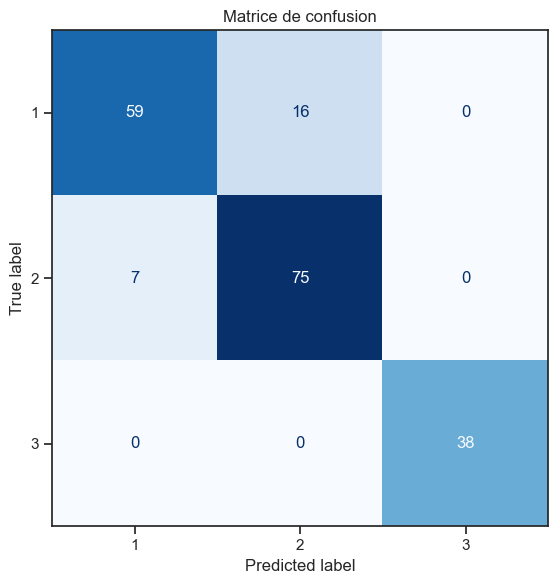

Pourcentage d'erreur : 11.79 %
              precision    recall  f1-score   support

           1       0.89      0.79      0.84        75
           2       0.82      0.91      0.87        82
           3       1.00      1.00      1.00        38

    accuracy                           0.88       195
   macro avg       0.91      0.90      0.90       195
weighted avg       0.89      0.88      0.88       195

F1-score macro : 0.9013


In [ ]:
# Régression multinomiale sans pénalisation
model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    C=1e10,  
    max_iter=1000,
    random_state=42
)

model.fit(X_train_encoded, y_train)
y_pred = model.predict(X_test_encoded)

# Coefficients par classe
coef_df = pd.DataFrame(model.coef_, columns=X_train_encoded.columns)
coef_df.index = model.classes_
print("Coefficients :")
print(coef_df)

# Matrice de confusion
conf_matrix = plot_confusion_matrix(y_test, y_pred, labels=model.classes_)
erreur_pourcentage(conf_matrix)

# Rapport de classification
print(classification_report(y_test, y_pred))
report_multi = classification_report(y_test, y_pred, output_dict=True)
f1_macro_multi = report_multi['macro avg']['f1-score']
f1_dico_comp["Multi reg"]=f1_macro_multi
print(f"F1-score macro : {f1_macro_multi:.4f}")

**Ridge** (pénalisation de la complexité)

In [43]:
# Sélection du lambda optimal par validation croisée 
ridge_cv = LogisticRegressionCV(
    Cs=np.logspace(-4, 2, 200),
    cv=cv,
    penalty="l2",
    solver="saga",
    multi_class="multinomial",
    scoring="neg_log_loss",
    max_iter=5000,
    n_jobs=-1,
    random_state=42
)
ridge_cv.fit(X_train_encoded, y_train) 

# Analyse des scores de validation croisée 
true_Cs = ridge_cv.Cs_
true_lambdas = 1 / np.array(true_Cs)

logloss_all = np.array([
    -ridge_cv.scores_[cls].mean(axis=0) for cls in ridge_cv.scores_.keys()
])
mean_logloss = logloss_all.mean(axis=0)
std_logloss = logloss_all.std(axis=0)

best_index = mean_logloss.argmin()
best_lambda_ridge = true_lambdas[best_index]


print(f"[Ridge] Best lambda : {best_lambda_ridge:.6f}")


[Ridge] Best lambda : 0.010000



Coefficients pour la classe 1:
Age                               -0.175492
sWeight (kg)                       0.062278
Height (m)                         0.039737
Max_BPM                           -0.038836
Avg_BPM                            0.558139
Resting_BPM                        0.008437
Session_Duration (hours)          -1.008169
sCalories_Burned                  -2.035765
BCFat_Percentage                   2.534380
Water_Intake (liters)             -0.205584
sBMI                              -0.001279
Gender_Male                        2.054705
Workout_Type_HIIT                 -0.139124
Workout_Type_Strength              0.104711
Workout_Type_Yoga                  0.144941
Workout_Frequency (days/week)_3   -2.573872
Workout_Frequency (days/week)_4   -7.978048
Workout_Frequency (days/week)_5   -0.754692
dtype: float64

Coefficients pour la classe 2:
Age                                0.106163
sWeight (kg)                       0.014272
Height (m)                         0.0593

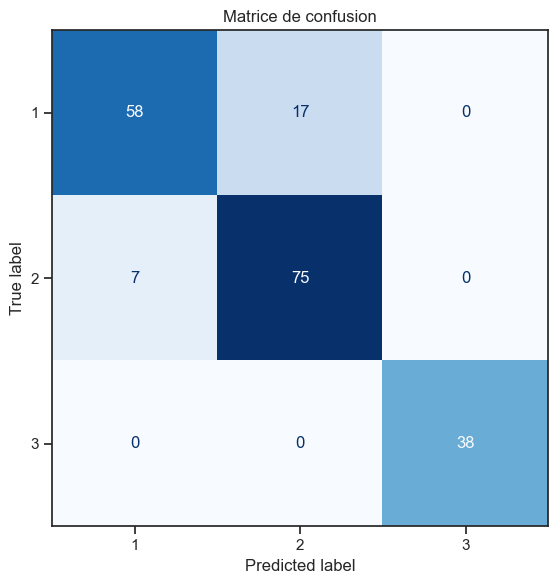

Pourcentage d'erreur : 12.31 %
Rapport de classification :
              precision    recall  f1-score   support

           1       0.89      0.77      0.83        75
           2       0.82      0.91      0.86        82
           3       1.00      1.00      1.00        38

    accuracy                           0.88       195
   macro avg       0.90      0.90      0.90       195
weighted avg       0.88      0.88      0.88       195

F1-score macro : 0.8969


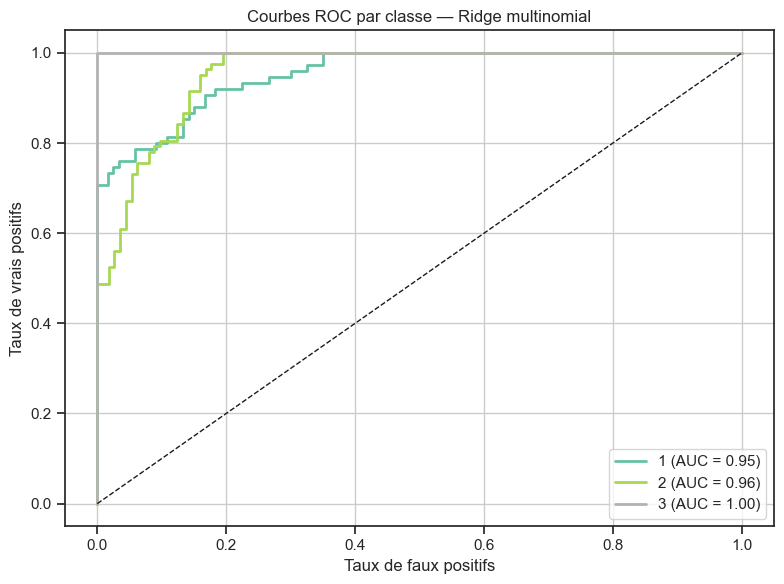

In [44]:
# Entraînement du modèle le meilleur lambda trouvé par CV
ridge_model = LogisticRegression(
    C=1 / best_lambda_ridge, 
    penalty='l2',
    solver='saga',
    multi_class='multinomial',
    max_iter=5000,
    random_state=42
)
ridge_model.fit(X_train_encoded, y_train)

# Prédictions
y_pred_ridge = ridge_model.predict(X_test_encoded)
y_proba_ridge = ridge_model.predict_proba(X_test_encoded)

# Coefficients par classe
for i, class_label in enumerate(ridge_model.classes_):
    print(f"\nCoefficients pour la classe {class_label}:")
    print(pd.Series(ridge_model.coef_[i], index=X_train_encoded.columns))

print("\nIntercepts (biais) pour chaque classe :")
print(ridge_model.intercept_)

# Évaluation
conf_matrix_ridge = plot_confusion_matrix(y_test, y_pred_ridge, labels=ridge_model.classes_)
erreur_pourcentage(conf_matrix_ridge)

print("Rapport de classification :")
print(classification_report(y_test, y_pred_ridge))
report_ridge = classification_report(y_test, y_pred_ridge, output_dict=True)
f1_macro_ridge = report_ridge['macro avg']['f1-score']
print(f"F1-score macro : {f1_macro_ridge:.4f}")
f1_dico_comp["Ridge"]=f1_macro_ridge
plot_roc_curves(
    y_true=y_test,
    y_probs=y_proba_ridge,
    class_names=ridge_model.classes_,
    model_name="Ridge multinomial"
)


**Lasso** (sélection de variables)

[Lasso] Best lambda : 0.100000


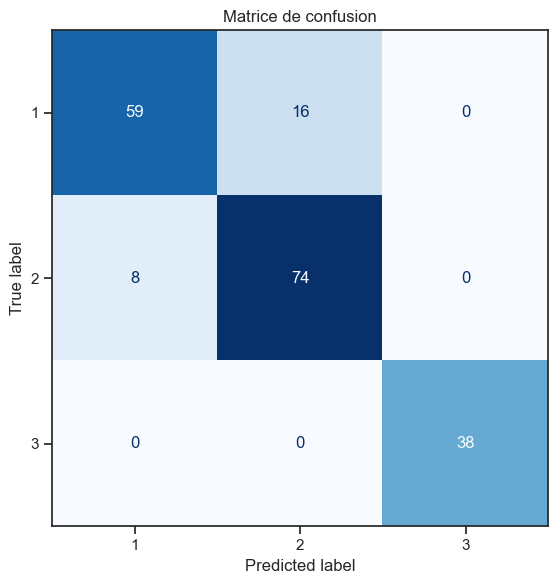

Pourcentage d'erreur : 12.31 %
Rapport Lasso :
              precision    recall  f1-score   support

           1       0.88      0.79      0.83        75
           2       0.82      0.90      0.86        82
           3       1.00      1.00      1.00        38

    accuracy                           0.88       195
   macro avg       0.90      0.90      0.90       195
weighted avg       0.88      0.88      0.88       195

F1-score macro : 0.8972


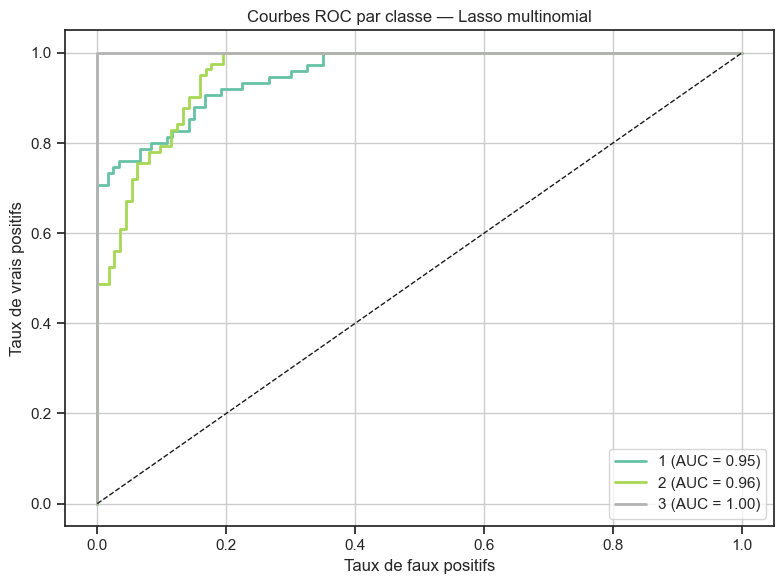

In [45]:
# Sélection du lambda optimal par validation croisée
lasso_cv = LogisticRegressionCV(
    Cs=np.logspace(-2.5, 1, 100),
    cv=cv,
    penalty='l1',
    solver='saga',
    multi_class='multinomial',
    scoring='neg_log_loss',
    max_iter=5000,
    n_jobs=-1,
    random_state=42
)
lasso_cv.fit(X_train_encoded, y_train)

#  Analyse des scores de validation croisée 
true_Cs = lasso_cv.Cs_
true_lambdas = 1 / np.array(true_Cs)

logloss_all = np.array([
    -lasso_cv.scores_[cls].mean(axis=0) for cls in lasso_cv.scores_.keys()
])
mean_logloss = logloss_all.mean(axis=0)
std_logloss = logloss_all.std(axis=0)

best_index = mean_logloss.argmin()
best_lambda_lasso = true_lambdas[best_index]




print(f"[Lasso] Best lambda : {best_lambda_lasso:.6f}")

#  Entraînement avec le meilleur lambda 
lasso_model = LogisticRegression(
    C=1 / best_lambda_lasso,
    penalty='l1',
    solver='saga',
    multi_class='multinomial',
    max_iter=5000,
    random_state=42
)
lasso_model.fit(X_train_encoded, y_train)

# évaluation 
y_pred_lasso = lasso_model.predict(X_test_encoded)
y_proba_lasso = lasso_model.predict_proba(X_test_encoded)

conf_matrix_lasso = plot_confusion_matrix(y_test, y_pred_lasso, labels=lasso_model.classes_)
erreur_pourcentage(conf_matrix_lasso)

print("Rapport Lasso :")
print(classification_report(y_test, y_pred_lasso))
report_lasso = classification_report(y_test, y_pred_lasso, output_dict=True)
f1_macro_lasso = report_lasso['macro avg']['f1-score']
print(f"F1-score macro : {f1_macro_lasso:.4f}")
f1_dico_comp["Lasso"]=f1_macro_lasso
plot_roc_curves(
    y_true=y_test,
    y_probs=y_proba_lasso,
    class_names=lasso_model.classes_,
    model_name="Lasso multinomial"
)





# 2.2.2 Classification par analyse discriminante

**LDA**

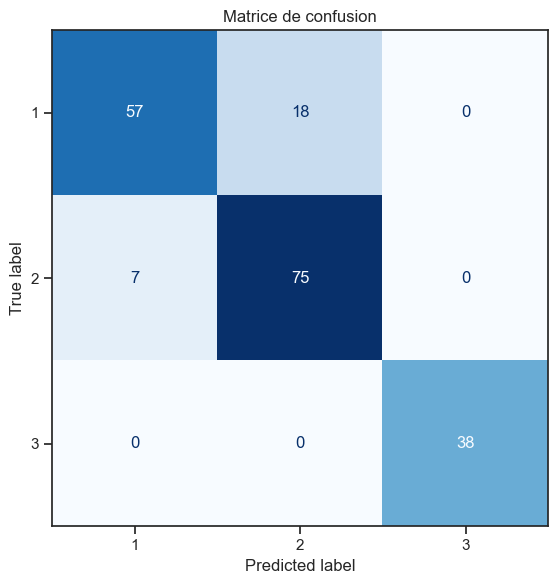

Pourcentage d'erreur : 12.82 %
Rapport LDA :
              precision    recall  f1-score   support

           1       0.89      0.76      0.82        75
           2       0.81      0.91      0.86        82
           3       1.00      1.00      1.00        38

    accuracy                           0.87       195
   macro avg       0.90      0.89      0.89       195
weighted avg       0.88      0.87      0.87       195

F1-score macro : 0.8924


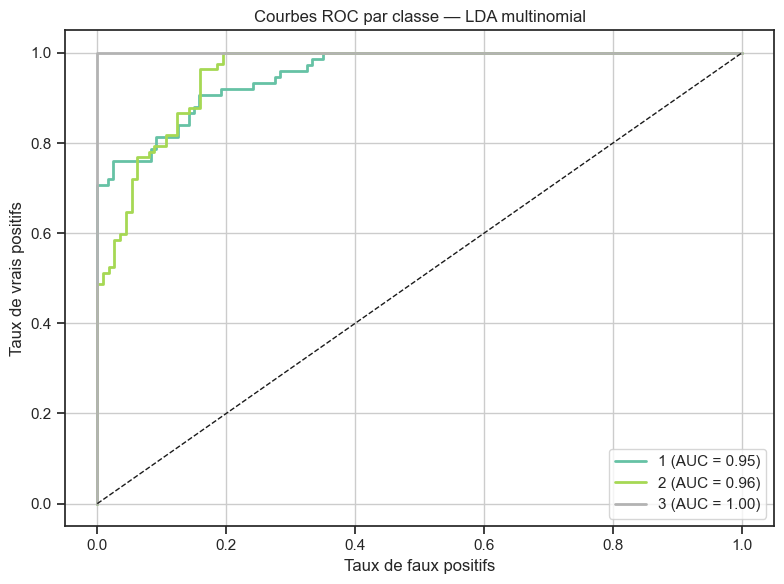

In [46]:

#  LDA 
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train_encoded, y_train)

# prédictions 
y_pred_lda = lda_model.predict(X_test_encoded)
y_proba_lda = lda_model.predict_proba(X_test_encoded)

# Évaluation
conf_matrix_lda = plot_confusion_matrix(y_test, y_pred_lda, labels=lda_model.classes_)
erreur_pourcentage(conf_matrix_lda)

print("Rapport LDA :")
print(classification_report(y_test, y_pred_lda))
report_lda = classification_report(y_test, y_pred_lda, output_dict=True)
f1_macro_lda = report_lda['macro avg']['f1-score']
print(f"F1-score macro : {f1_macro_lda:.4f}")
f1_dico_comp["LDA"]=f1_macro_lda
plot_roc_curves(
    y_true=y_test,
    y_probs=y_proba_lda,
    class_names=lda_model.classes_,
    model_name="LDA multinomial"
)




**kNN**

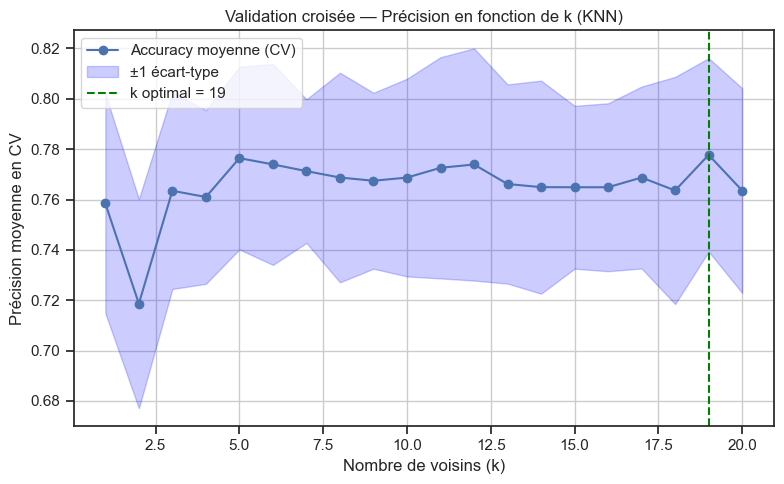

[KNN] Meilleur k (nombre de voisins) : 19


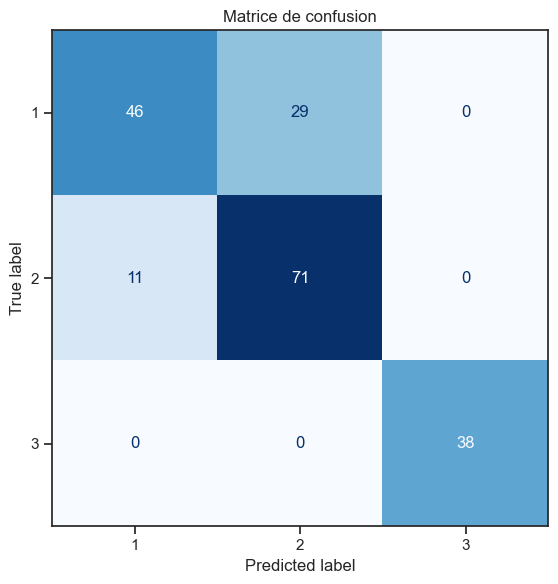

Pourcentage d'erreur : 20.51 %
Rapport KNN :
              precision    recall  f1-score   support

           1       0.81      0.61      0.70        75
           2       0.71      0.87      0.78        82
           3       1.00      1.00      1.00        38

    accuracy                           0.79       195
   macro avg       0.84      0.83      0.83       195
weighted avg       0.80      0.79      0.79       195

F1-score macro : 0.8257


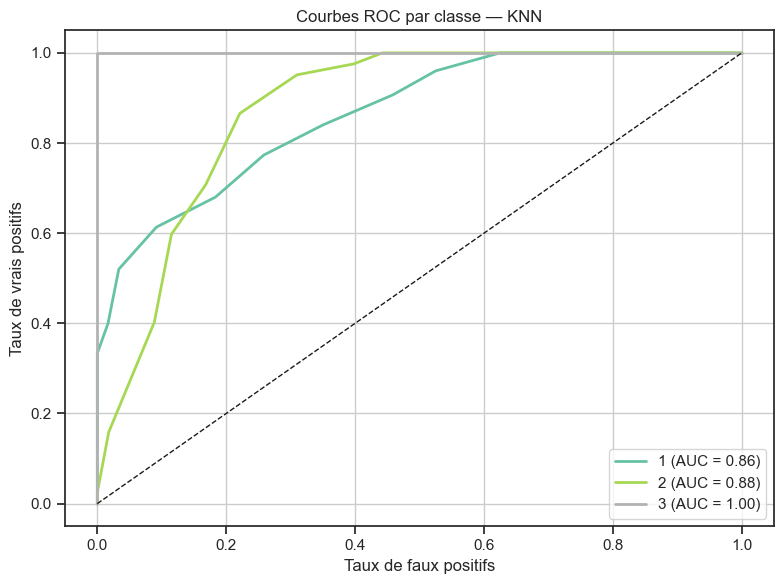

In [47]:

# Grille de paramètres pour le nombre de voisins 
param_grid = {'n_neighbors': list(range(1, 21))}

knn_grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# entraînement avec cross-validation 
knn_grid.fit(X_train_encoded, y_train)

best_k = knn_grid.best_params_["n_neighbors"]

k_values = knn_grid.cv_results_['param_n_neighbors'].data.astype(int)
mean_scores = knn_grid.cv_results_['mean_test_score']
std_scores = knn_grid.cv_results_['std_test_score']


plt.figure(figsize=(8, 5))
plt.plot(k_values, mean_scores, marker='o', label="Accuracy moyenne (CV)")
plt.fill_between(
    k_values,
    mean_scores - std_scores,
    mean_scores + std_scores,
    alpha=0.2,
    color='blue',
    label="±1 écart-type"
)
plt.axvline(best_k, color='green', linestyle='--', label=f"k optimal = {best_k}")
plt.xlabel("Nombre de voisins (k)")
plt.ylabel("Précision moyenne en CV")
plt.title("Validation croisée — Précision en fonction de k (KNN)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


print(f"[KNN] Meilleur k (nombre de voisins) : {best_k}")

#entraînement final avec le meilleur k 
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train_encoded, y_train)

y_pred_knn = knn_model.predict(X_test_encoded)
y_proba_knn = knn_model.predict_proba(X_test_encoded)

conf_matrix_knn = plot_confusion_matrix(y_test, y_pred_knn, labels=knn_model.classes_)
erreur_pourcentage(conf_matrix_knn)

print("Rapport KNN :")
print(classification_report(y_test, y_pred_knn))
report_knn = classification_report(y_test, y_pred_knn, output_dict=True)
f1_macro_knn = report_knn['macro avg']['f1-score']
print(f"F1-score macro : {f1_macro_knn:.4f}")
f1_dico_comp["kNN"]=f1_macro_knn

plot_roc_curves(
    y_true=y_test,
    y_probs=y_proba_knn,
    class_names=knn_model.classes_,
    model_name="KNN"
)



****SVM linéaire****

[SVM linéaire] Meilleur C : 0.2336


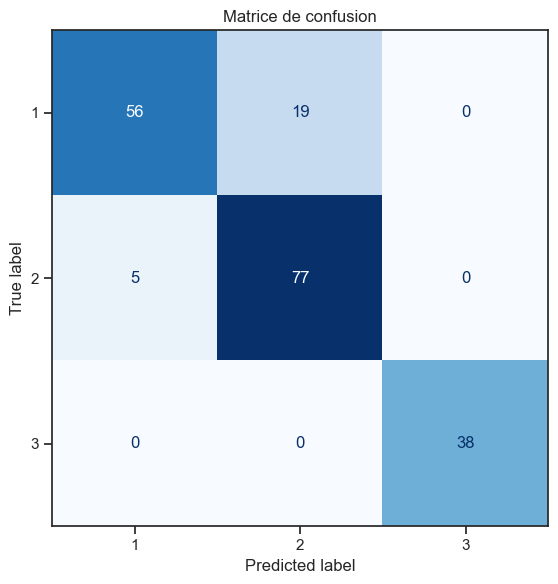

Pourcentage d'erreur : 12.31 %
Rapport SVM linéaire :
              precision    recall  f1-score   support

           1       0.92      0.75      0.82        75
           2       0.80      0.94      0.87        82
           3       1.00      1.00      1.00        38

    accuracy                           0.88       195
   macro avg       0.91      0.90      0.90       195
weighted avg       0.89      0.88      0.88       195

F1-score macro : 0.8962


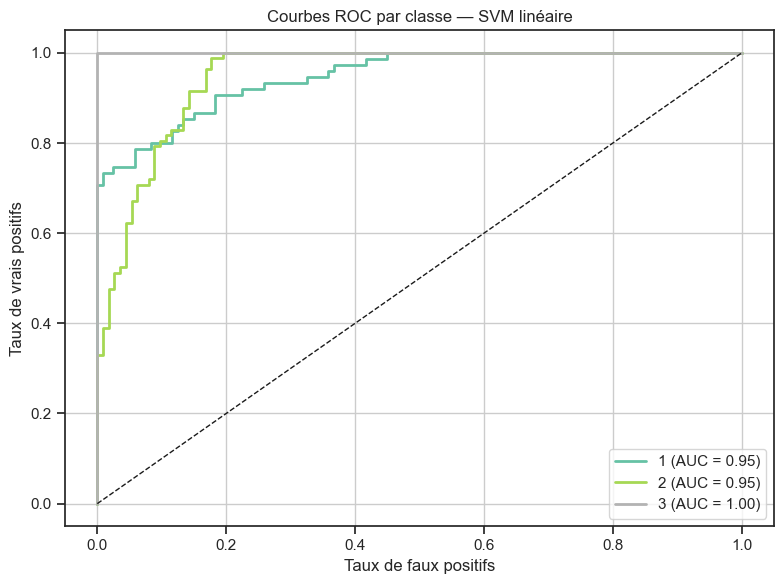

In [48]:


# --- Grille de valeurs pour le paramètre C ---
param_grid_svm = {'C': np.logspace(-3, 2, 20)}

svm_lin_grid = GridSearchCV(
    estimator=SVC(kernel='linear', probability=True),  # probability=True = pour ROC
    param_grid=param_grid_svm,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# --- Entraînement avec cross-validation ---
svm_lin_grid.fit(X_train_encoded, y_train)

best_C_svm_lin = svm_lin_grid.best_params_["C"]
print(f"[SVM linéaire] Meilleur C : {best_C_svm_lin:.4f}")

# --- Entraînement final avec le meilleur C ---
svm_lin_model = SVC(
    kernel='linear',
    C=best_C_svm_lin,
    probability=True,
    random_state=42
)
svm_lin_model.fit(X_train_encoded, y_train)

# --- Prédictions ---
y_pred_svm_lin = svm_lin_model.predict(X_test_encoded)
y_proba_svm_lin = svm_lin_model.predict_proba(X_test_encoded)

# --- Évaluation ---
conf_matrix_svm_lin = plot_confusion_matrix(y_test, y_pred_svm_lin, labels=svm_lin_model.classes_)
erreur_pourcentage(conf_matrix_svm_lin)

print("Rapport SVM linéaire :")
print(classification_report(y_test, y_pred_svm_lin))
report_svm_lin = classification_report(y_test, y_pred_svm_lin, output_dict=True)
f1_macro_svm_lin = report_svm_lin['macro avg']['f1-score']
print(f"F1-score macro : {f1_macro_svm_lin:.4f}")
f1_dico_comp["SVM Lin"]=f1_macro_svm_lin 
# --- Courbes ROC ---
plot_roc_curves(
    y_true=y_test,
    y_probs=y_proba_svm_lin,
    class_names=svm_lin_model.classes_,
    model_name="SVM linéaire"
)





****SVM kernel radial****

[SVM RBF] Meilleur C : 35.93813663804626
[SVM RBF] Meilleur gamma : 0.004641588833612782


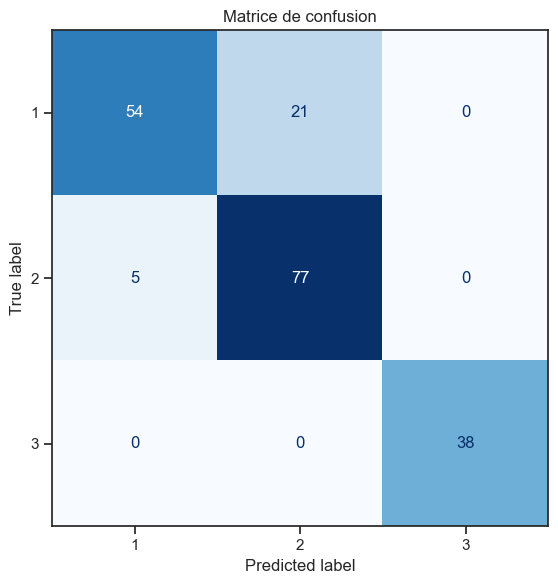

Pourcentage d'erreur : 13.33 %
Rapport SVM RBF :
              precision    recall  f1-score   support

           1       0.92      0.72      0.81        75
           2       0.79      0.94      0.86        82
           3       1.00      1.00      1.00        38

    accuracy                           0.87       195
   macro avg       0.90      0.89      0.89       195
weighted avg       0.88      0.87      0.86       195

F1-score macro : 0.8872


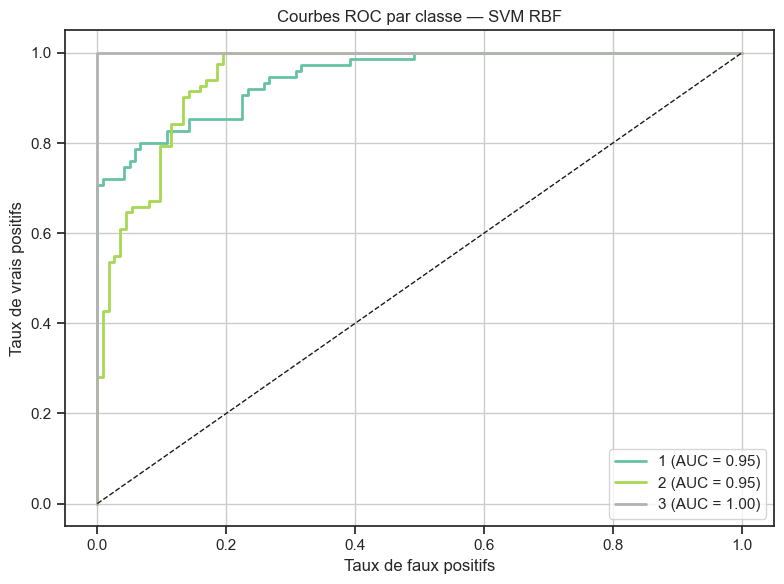

In [49]:
# --- Grille de recherche conjointe pour C et gamma ---
param_grid_rbf = {
    'C': np.logspace(-2, 2, 10),
    'gamma': np.logspace(-4, 1, 10)
}

svm_rbf_grid = GridSearchCV(
    estimator=SVC(kernel='rbf', probability=True),
    param_grid=param_grid_rbf,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# --- Entraînement avec cross-validation ---
svm_rbf_grid.fit(X_train_encoded, y_train)

best_params_rbf = svm_rbf_grid.best_params_
best_C_rbf = best_params_rbf['C']
best_gamma_rbf = best_params_rbf['gamma']

print(f"[SVM RBF] Meilleur C : {best_C_rbf}")
print(f"[SVM RBF] Meilleur gamma : {best_gamma_rbf}")

# --- Entraînement final avec les meilleurs hyperparamètres ---
svm_rbf_model = SVC(
    kernel='rbf',
    C=best_C_rbf,
    gamma=best_gamma_rbf,
    probability=True,
    random_state=42
)
svm_rbf_model.fit(X_train_encoded, y_train)

# --- Prédictions ---
y_pred_svm_rbf = svm_rbf_model.predict(X_test_encoded)
y_proba_svm_rbf = svm_rbf_model.predict_proba(X_test_encoded)

# --- Évaluation ---
conf_matrix_svm_rbf = plot_confusion_matrix(y_test, y_pred_svm_rbf, labels=svm_rbf_model.classes_)
erreur_pourcentage(conf_matrix_svm_rbf)

print("Rapport SVM RBF :")
print(classification_report(y_test, y_pred_svm_rbf))
report_svm_rbf = classification_report(y_test, y_pred_svm_rbf, output_dict=True)
f1_macro_svm_rbf = report_svm_rbf['macro avg']['f1-score']
print(f"F1-score macro : {f1_macro_svm_rbf:.4f}")
f1_dico_comp["SVM RBF"]=f1_macro_svm_rbf
# --- Courbes ROC ---
plot_roc_curves(
    y_true=y_test,
    y_probs=y_proba_svm_rbf,
    class_names=svm_rbf_model.classes_,
    model_name="SVM RBF"
)





****SVM kernel polynomial****

[SVM Polynomial] Meilleur C : 0.1
[SVM Polynomial] Meilleur gamma : 0.5623413251903491
[SVM Polynomial] Meilleur degree : 2


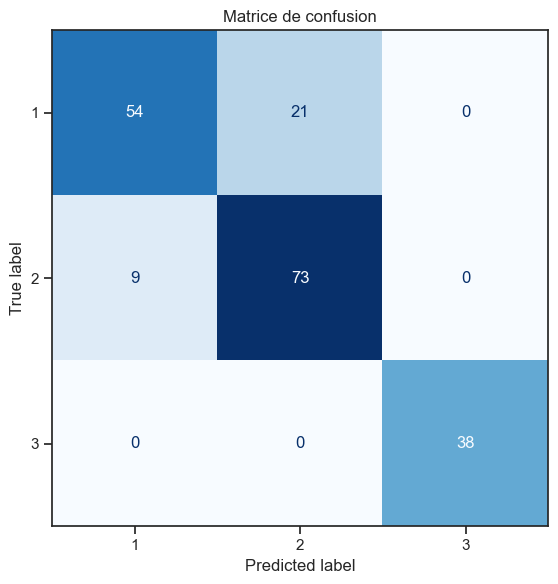

Pourcentage d'erreur : 15.38 %
Rapport SVM Polynomial :
              precision    recall  f1-score   support

           1       0.86      0.72      0.78        75
           2       0.78      0.89      0.83        82
           3       1.00      1.00      1.00        38

    accuracy                           0.85       195
   macro avg       0.88      0.87      0.87       195
weighted avg       0.85      0.85      0.84       195

F1-score macro : 0.8707


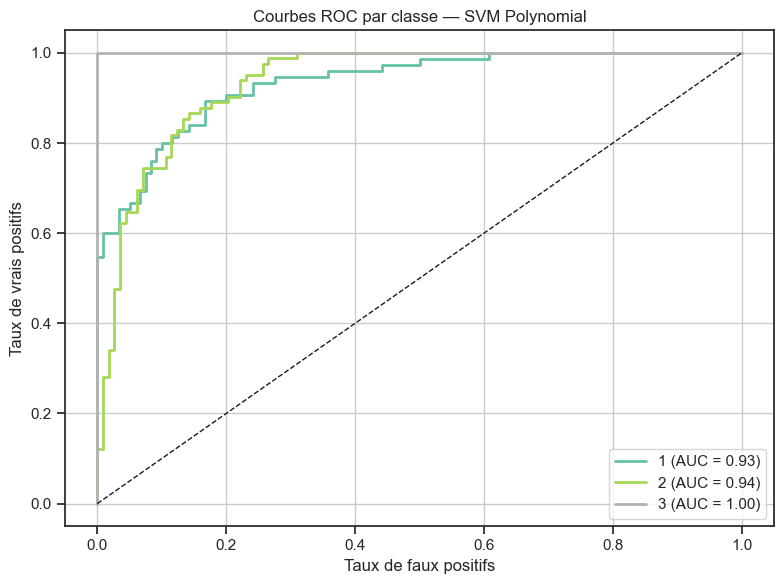

In [50]:
# --- Grille de paramètres pour SVM polynomial ---
param_grid_poly = {
    'C': np.logspace(-2, 2, 5),
    'gamma': np.logspace(-4, 1, 5),
    'degree': [2, 3, 4]
}

svm_poly_grid = GridSearchCV(
    estimator=SVC(kernel='poly', probability=True),
    param_grid=param_grid_poly,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# --- Entraînement avec cross-validation ---
svm_poly_grid.fit(X_train_encoded, y_train)

best_params_poly = svm_poly_grid.best_params_
best_C_poly = best_params_poly['C']
best_gamma_poly = best_params_poly['gamma']
best_degree_poly = best_params_poly['degree']

print(f"[SVM Polynomial] Meilleur C : {best_C_poly}")
print(f"[SVM Polynomial] Meilleur gamma : {best_gamma_poly}")
print(f"[SVM Polynomial] Meilleur degree : {best_degree_poly}")

# --- Entraînement final ---
svm_poly_model = SVC(
    kernel='poly',
    C=best_C_poly,
    gamma=best_gamma_poly,
    degree=best_degree_poly,
    probability=True,
    random_state=42
)
svm_poly_model.fit(X_train_encoded, y_train)

# --- Prédictions ---
y_pred_svm_poly = svm_poly_model.predict(X_test_encoded)
y_proba_svm_poly = svm_poly_model.predict_proba(X_test_encoded)

# --- Évaluation ---
conf_matrix_svm_poly = plot_confusion_matrix(y_test, y_pred_svm_poly, labels=svm_poly_model.classes_)
erreur_pourcentage(conf_matrix_svm_poly)

print("Rapport SVM Polynomial :")
print(classification_report(y_test, y_pred_svm_poly))
report_svm_poly = classification_report(y_test, y_pred_svm_poly, output_dict=True)
f1_macro_svm_poly = report_svm_poly['macro avg']['f1-score']
print(f"F1-score macro : {f1_macro_svm_poly:.4f}")
f1_dico_comp["SVM Poly"]=f1_macro_svm_poly
# --- Courbes ROC ---
plot_roc_curves(
    y_true=y_test,
    y_probs=y_proba_svm_poly,
    class_names=svm_poly_model.classes_,
    model_name="SVM Polynomial"
)




# 2.2.4 Arbres et forêts aléatoires


**Abres binaires de décision** (CART)

[CART] Meilleure profondeur (max_depth) : 4


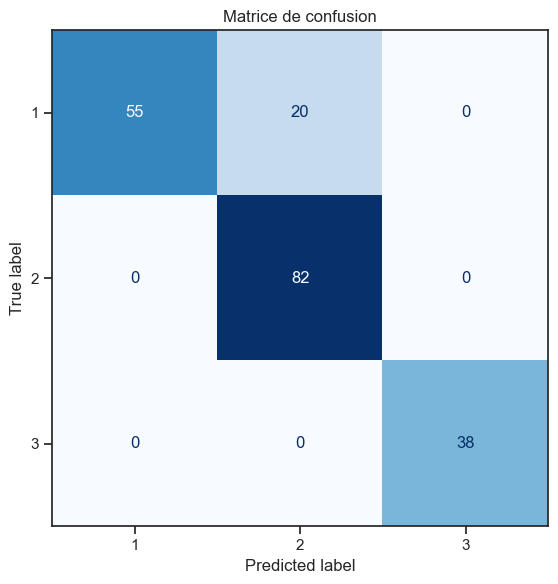

Pourcentage d'erreur : 10.26 %
Rapport CART :
              precision    recall  f1-score   support

           1       1.00      0.73      0.85        75
           2       0.80      1.00      0.89        82
           3       1.00      1.00      1.00        38

    accuracy                           0.90       195
   macro avg       0.93      0.91      0.91       195
weighted avg       0.92      0.90      0.90       195

F1-score macro : 0.9125


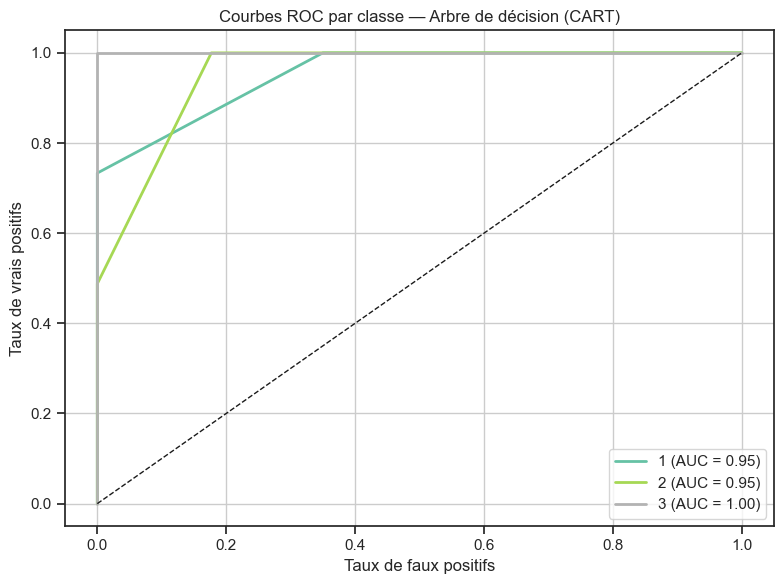

In [51]:

# --- Grille de paramètres : profondeur maximale de l'arbre ---
param_grid_cart = {'max_depth': list(range(2, 15))}

cart_grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_cart,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# --- Entraînement avec validation croisée ---
cart_grid.fit(X_train_encoded, y_train)

best_depth_cart = cart_grid.best_params_['max_depth']
print(f"[CART] Meilleure profondeur (max_depth) : {best_depth_cart}")

# --- Entraînement final avec la profondeur optimale ---
cart_model = DecisionTreeClassifier(max_depth=best_depth_cart, random_state=42)
cart_model.fit(X_train_encoded, y_train)

# --- Prédictions ---
y_pred_cart = cart_model.predict(X_test_encoded)
y_proba_cart = cart_model.predict_proba(X_test_encoded)

# --- Évaluation ---
conf_matrix_cart = plot_confusion_matrix(y_test, y_pred_cart, labels=cart_model.classes_)
erreur_pourcentage(conf_matrix_cart)

print("Rapport CART :")
print(classification_report(y_test, y_pred_cart))
report_cart = classification_report(y_test, y_pred_cart, output_dict=True)
f1_macro_cart = report_cart['macro avg']['f1-score']
print(f"F1-score macro : {f1_macro_cart:.4f}")
f1_dico_comp["CART"]=f1_macro_cart
# --- Courbes ROC ---
plot_roc_curves(
    y_true=y_test,
    y_probs=y_proba_cart,
    class_names=cart_model.classes_,
    model_name="Arbre de décision (CART)"
)






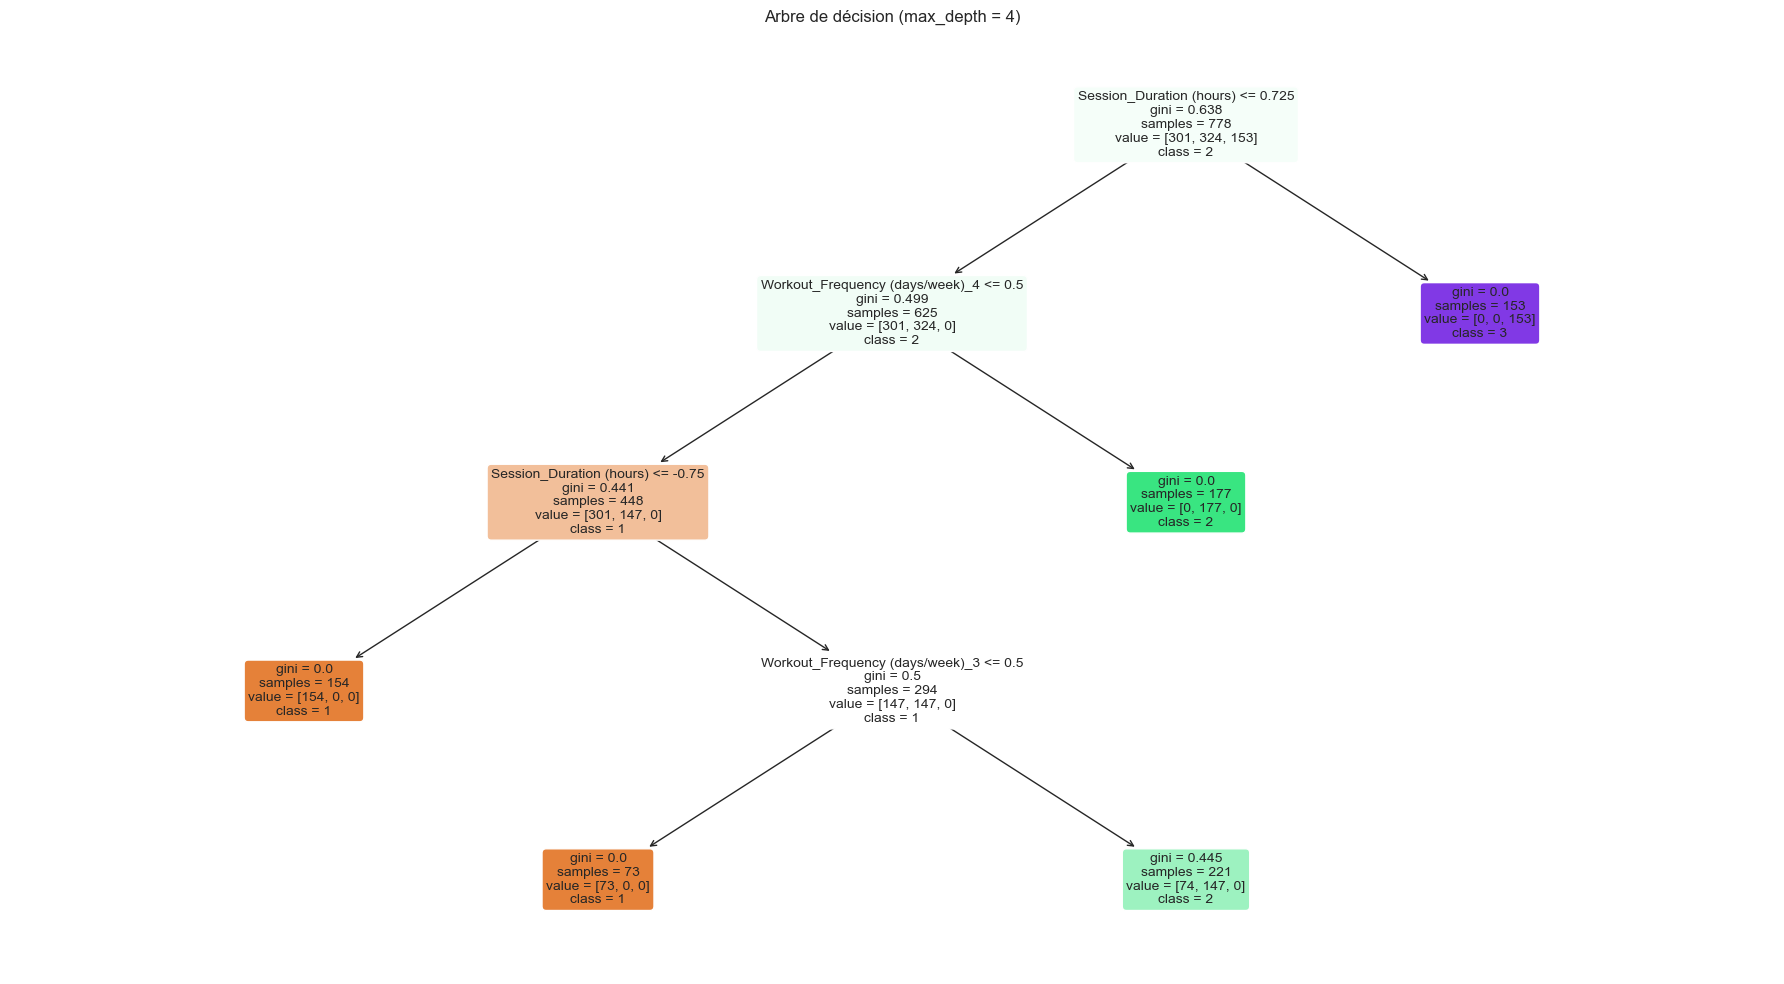

In [52]:


plt.figure(figsize=(18, 10))
plot_tree(
    cart_model,
    feature_names=X_train_encoded.columns,
    class_names=[str(cls) for cls in cart_model.classes_],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title(f"Arbre de décision (max_depth = {best_depth_cart})")
plt.tight_layout()
plt.show()


**Forêts aléatoires**

[Random Forest] Meilleur n_estimators : 200
[Random Forest] Meilleur max_depth : 7


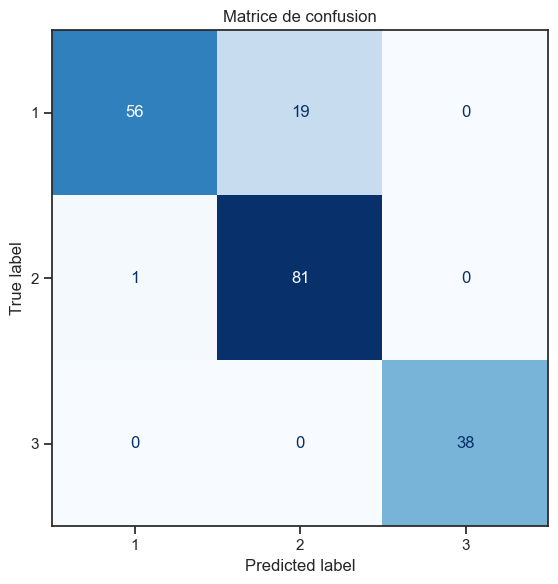

Pourcentage d'erreur : 10.26 %
Rapport Random Forest :
              precision    recall  f1-score   support

           1       0.98      0.75      0.85        75
           2       0.81      0.99      0.89        82
           3       1.00      1.00      1.00        38

    accuracy                           0.90       195
   macro avg       0.93      0.91      0.91       195
weighted avg       0.91      0.90      0.90       195

F1-score macro : 0.9129


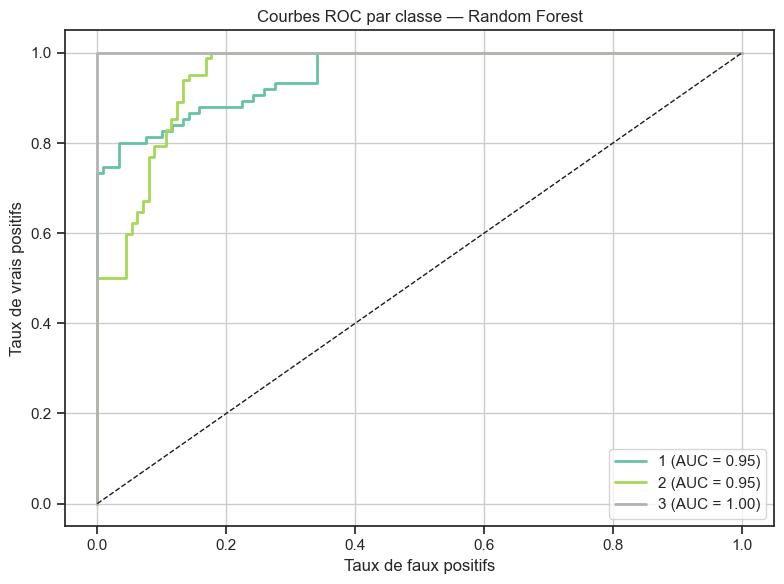

In [53]:


# --- Grille de recherche pour Random Forest ---
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10, None]
}

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# --- Entraînement avec validation croisée ---
rf_grid.fit(X_train_encoded, y_train)

best_params_rf = rf_grid.best_params_
best_n_estimators = best_params_rf['n_estimators']
best_max_depth = best_params_rf['max_depth']

print(f"[Random Forest] Meilleur n_estimators : {best_n_estimators}")
print(f"[Random Forest] Meilleur max_depth : {best_max_depth}")

# --- Entraînement final ---
rf_model = RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    random_state=42
)
rf_model.fit(X_train_encoded, y_train)

# --- Prédictions ---
y_pred_rf = rf_model.predict(X_test_encoded)
y_proba_rf = rf_model.predict_proba(X_test_encoded)

# --- Évaluation ---
conf_matrix_rf = plot_confusion_matrix(y_test, y_pred_rf, labels=rf_model.classes_)
erreur_pourcentage(conf_matrix_rf)

print("Rapport Random Forest :")
print(classification_report(y_test, y_pred_rf))
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
f1_macro_rf = report_rf['macro avg']['f1-score']
print(f"F1-score macro : {f1_macro_rf:.4f}")
f1_dico_comp["Random Forest"]=f1_macro_rf
# --- Courbes ROC ---
plot_roc_curves(
    y_true=y_test,
    y_probs=y_proba_rf,
    class_names=rf_model.classes_,
    model_name="Random Forest"
)





**Boosting**

[Gradient Boosting] Best params : {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


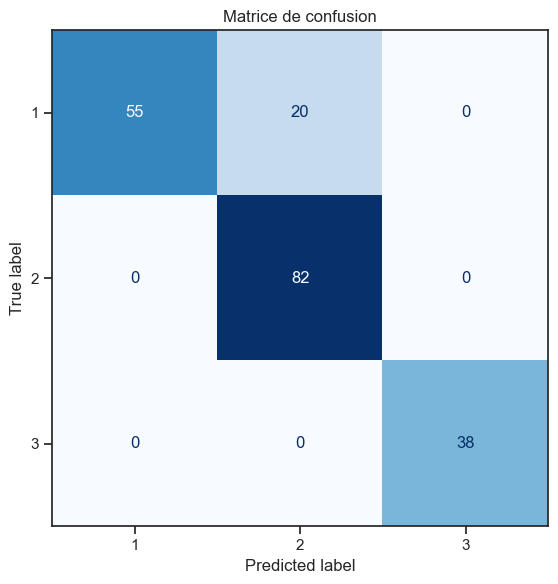

Pourcentage d'erreur : 10.26 %
Rapport Gradient Boosting :
              precision    recall  f1-score   support

           1       1.00      0.73      0.85        75
           2       0.80      1.00      0.89        82
           3       1.00      1.00      1.00        38

    accuracy                           0.90       195
   macro avg       0.93      0.91      0.91       195
weighted avg       0.92      0.90      0.90       195

F1-score macro : 0.9125


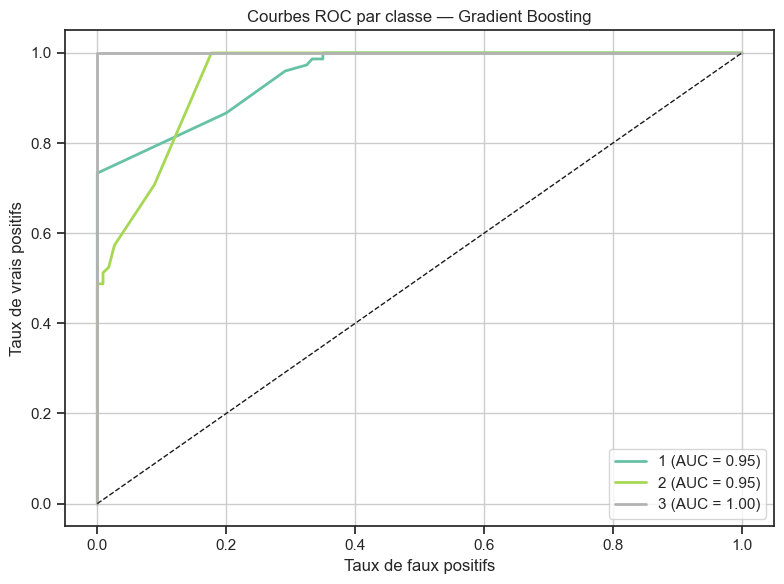

In [54]:

# --- Grille de paramètres ---
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7]
}

gb_grid = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid_gb,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# --- Entraînement avec validation croisée ---
gb_grid.fit(X_train_encoded, y_train)

best_params_gb = gb_grid.best_params_
print(f"[Gradient Boosting] Best params : {best_params_gb}")

# --- Entraînement final ---
gb_model = GradientBoostingClassifier(
    n_estimators=best_params_gb['n_estimators'],
    learning_rate=best_params_gb['learning_rate'],
    max_depth=best_params_gb['max_depth'],
    random_state=42
)
gb_model.fit(X_train_encoded, y_train)

# --- Prédictions ---
y_pred_gb = gb_model.predict(X_test_encoded)
y_proba_gb = gb_model.predict_proba(X_test_encoded)

# --- Évaluation ---
conf_matrix_gb = plot_confusion_matrix(y_test, y_pred_gb, labels=gb_model.classes_)
erreur_pourcentage(conf_matrix_gb)

print("Rapport Gradient Boosting :")
print(classification_report(y_test, y_pred_gb))
report_GradBoost = classification_report(y_test, y_pred_gb, output_dict=True)
f1_macro_GradBoost = report_GradBoost['macro avg']['f1-score']
print(f"F1-score macro : {f1_macro_GradBoost:.4f}")
f1_dico_comp["Grad Boosting"]=f1_macro_GradBoost
# --- Courbes ROC ---
plot_roc_curves(
    y_true=y_test,
    y_probs=y_proba_gb,
    class_names=gb_model.classes_,
    model_name="Gradient Boosting"
)





**XGBoost**

[XGBoost] Best parameters : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


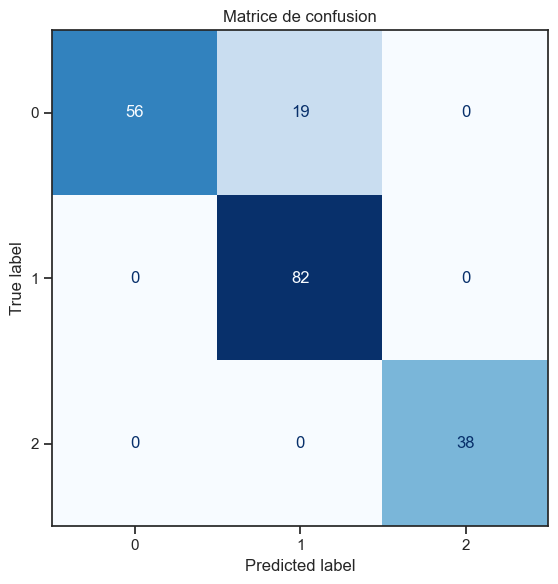

Pourcentage d'erreur : 9.74 %
Rapport XGBoost :
              precision    recall  f1-score   support

           0       1.00      0.75      0.85        75
           1       0.81      1.00      0.90        82
           2       1.00      1.00      1.00        38

    accuracy                           0.90       195
   macro avg       0.94      0.92      0.92       195
weighted avg       0.92      0.90      0.90       195

F1-score macro : 0.9170


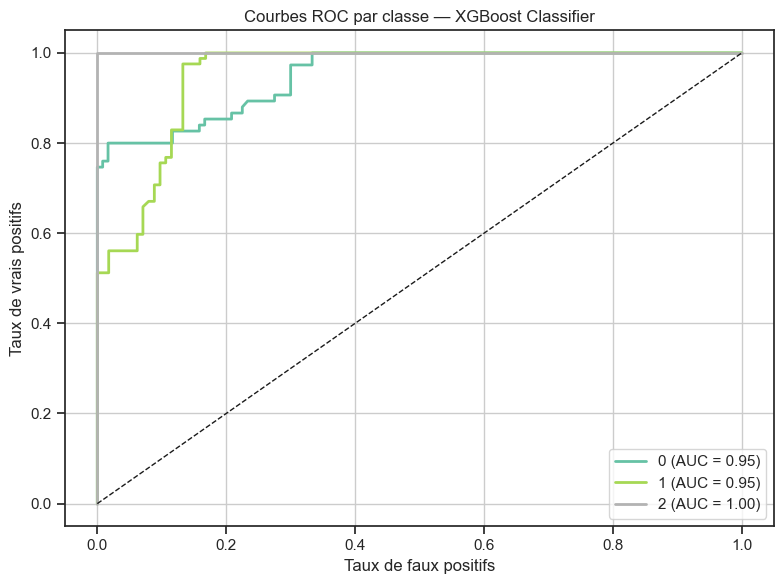

In [55]:


# Encodage des classes pour XGBoost (attend des entiers 0, 1, 2)
y_train_xgb = y_train.astype('category').cat.codes
y_test_xgb = y_test.astype('category').cat.codes
class_names_xgb = np.unique(y_train_xgb)

#  Grille d’hyperparamètres
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7]
}

xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(class_names_xgb),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

xgb_grid = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid_xgb,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

#  Grid search avec validation croisée
xgb_grid.fit(X_train_encoded, y_train_xgb)
best_params_xgb = xgb_grid.best_params_
print(f"[XGBoost] Best parameters : {best_params_xgb}")

#  Entraînement final avec les meilleurs hyperparamètres
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(class_names_xgb),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    **best_params_xgb
)
xgb_model.fit(X_train_encoded, y_train_xgb)

#  Prédictions et probabilités
y_pred_xgb = xgb_model.predict(X_test_encoded)
y_proba_xgb = xgb_model.predict_proba(X_test_encoded)

#  Évaluation
conf_matrix_xgb = plot_confusion_matrix(y_test_xgb, y_pred_xgb, labels=class_names_xgb)
erreur_pourcentage(conf_matrix_xgb)

print("Rapport XGBoost :")
print(classification_report(y_test_xgb, y_pred_xgb))
report_XGBoost = classification_report(y_test_xgb, y_pred_xgb, output_dict=True)
f1_macro_XGBoost = report_XGBoost['macro avg']['f1-score']
print(f"F1-score macro : {f1_macro_XGBoost:.4f}")
f1_dico_comp["XGBoost"]=f1_macro_XGBoost
plot_roc_curves(
    y_true=y_test_xgb,
    y_probs=y_proba_xgb,
    class_names=class_names_xgb,
    model_name="XGBoost Classifier"
)




# 2.2.5 RdN

Epoch 1/300
20/20 [==============================] - 1s 8ms/step - loss: 0.9717 - accuracy: 0.5370 - val_loss: 0.7960 - val_accuracy: 0.7628
Epoch 2/300
20/20 [==============================] - 0s 2ms/step - loss: 0.6846 - accuracy: 0.7749 - val_loss: 0.5340 - val_accuracy: 0.7692
Epoch 3/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4576 - accuracy: 0.8376 - val_loss: 0.3962 - val_accuracy: 0.8013
Epoch 4/300
20/20 [==============================] - 0s 2ms/step - loss: 0.3693 - accuracy: 0.8232 - val_loss: 0.3481 - val_accuracy: 0.8397
Epoch 5/300
20/20 [==============================] - 0s 3ms/step - loss: 0.3092 - accuracy: 0.8569 - val_loss: 0.3291 - val_accuracy: 0.8205
Epoch 6/300
20/20 [==============================] - 0s 3ms/step - loss: 0.2853 - accuracy: 0.8601 - val_loss: 0.3291 - val_accuracy: 0.8141
Epoch 7/300
20/20 [==============================] - 0s 2ms/step - loss: 0.2901 - accuracy: 0.8537 - val_loss: 0.3207 - val_accuracy: 0.8205
Epoch 8/300
2

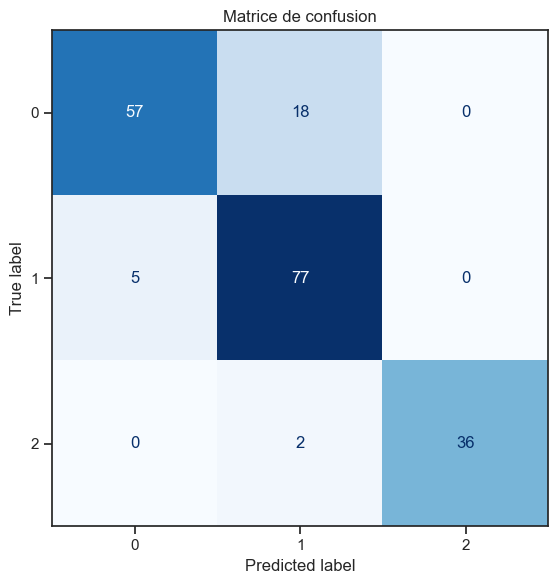

Pourcentage d'erreur : 12.82 %
Rapport MLP (TensorFlow) :
F1-score macro : 0.8885


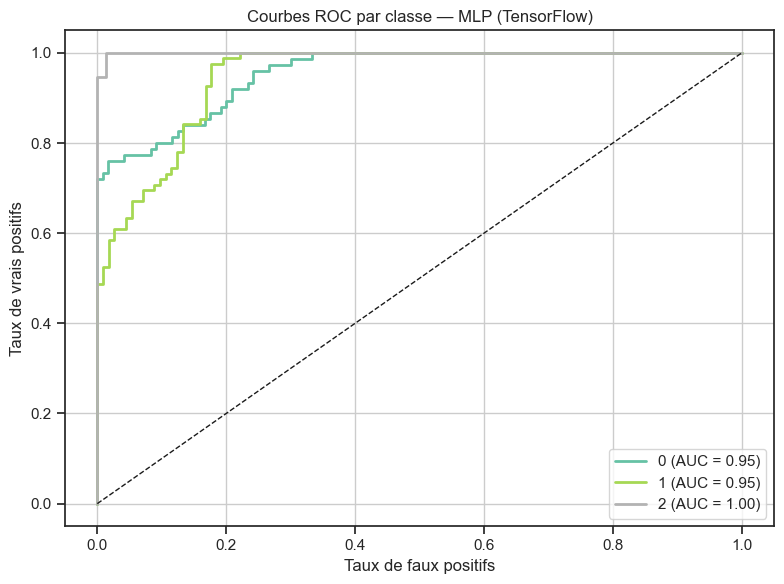

In [56]:
#  Variables retenues (corrélées à la cible)
mlp_features = [
    'Gender', 'Workout_Type', 'Workout_Frequency (days/week)',
    'Session_Duration (hours)', 'Avg_BPM', 'sCalories_Burned'
]

#  Extraction des features + encodage
X_train_raw = data_exp_norm[mlp_features]
X_test_raw = data_test_norm[mlp_features]

y_train_tf = data_exp_norm['Experience_Level'].astype(int) - 1  
y_test_tf = data_test_norm['Experience_Level'].astype(int) - 1

X_train_encoded = pd.get_dummies(X_train_raw, drop_first=False)
X_test_encoded = pd.get_dummies(X_test_raw, drop_first=False)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Standardisation
scaler_mlp = StandardScaler()
X_train_scaled = scaler_mlp.fit_transform(X_train_encoded)
X_test_scaled = scaler_mlp.transform(X_test_encoded)


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#  Architecture du MLP
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(3, activation='softmax')  
])

mlp_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# Entraînement
history = mlp_model.fit(
    X_train_scaled,
    y_train_tf,
    epochs=300,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Prédictions
y_proba_mlp = mlp_model.predict(X_test_scaled)
y_pred_mlp = np.argmax(y_proba_mlp, axis=1)

#  Matrice de confusion
conf_matrix_mlp = plot_confusion_matrix(y_test_tf, y_pred_mlp, labels=[0, 1, 2])
erreur_pourcentage(conf_matrix_mlp)

#  Rapport de classification
print("Rapport MLP (TensorFlow) :")
report_MLP = classification_report(y_test_tf, y_pred_mlp, output_dict=True)
f1_macro_MLP = report_MLP['macro avg']['f1-score']
print(f"F1-score macro : {f1_macro_MLP:.4f}")
f1_dico_comp["MLP"]=f1_macro_MLP
#  Courbes ROC
plot_roc_curves(
    y_true=y_test_tf,
    y_probs=y_proba_mlp,
    class_names=[0, 1, 2],
    model_name="MLP (TensorFlow)"
)



# Comparaison des méthodes

{'Multi reg': 0.9013104852485002, 'Ridge': 0.8968801313628901, 'Lasso': 0.8971503439240092, 'LDA': 0.8924289140116478, 'kNN': 0.8257298257298258, 'SVM Lin': 0.8962326503635163, 'SVM RBF': 0.8871752349364289, 'SVM Poly': 0.8707180500658761, 'CART': 0.9124860646599777, 'Random Forest': 0.9128649128649129, 'Grad Boosting': 0.9124860646599777, 'XGBoost': 0.9170455651496824, 'MLP': 0.8884749856082891}


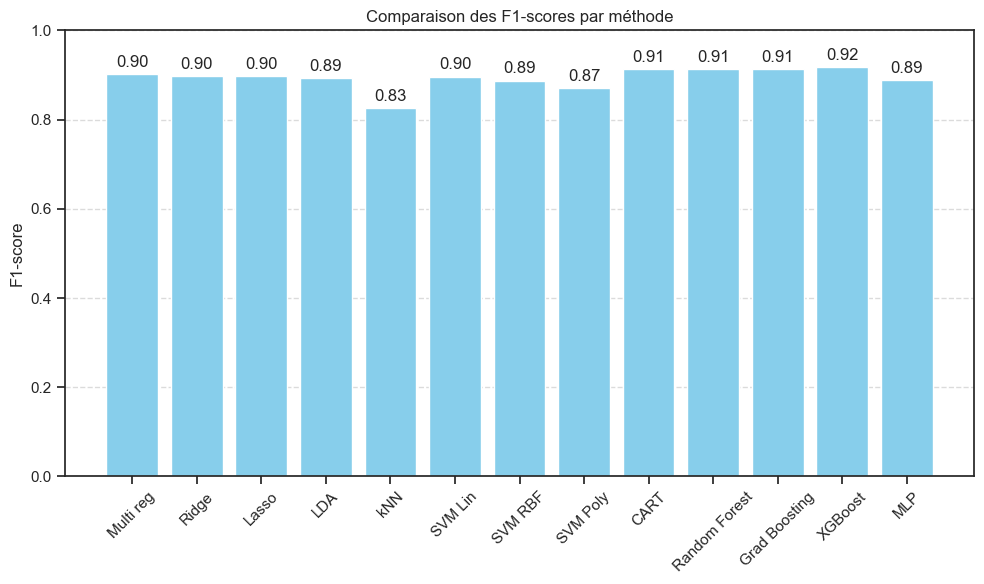

In [58]:
print(f1_dico_comp)
# Exemple de dictionnaire avec F1-scores
f1_scores=f1_dico_comp
# Préparer les données
methods = list(f1_scores.keys())
scores = list(f1_scores.values())

# Tracé
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, scores, color='skyblue')
plt.ylim(0, 1)
plt.ylabel('F1-score')
plt.title('Comparaison des F1-scores par méthode')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher les valeurs sur les barres
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

| Méthode                      | F1-score  | Remarque                                                                                                                                                |
| ---------------------------- | --------- | ------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **XGBoost**                  | **0.92**  | Meilleure performance. Excellent compromis biais-variance, robuste au surapprentissage, efficace avec peu de réglages.                                  |
| **Random Forest**            | 0.91      | Très bon score. Robuste, peu sensible aux données bruitées.                                                                                             |
| **Gradient Boosting**        | 0.91      | Comparable à XGBoost, mais souvent un peu plus lent à entraîner.                                                                                        |
| **CART (Arbre)**             | 0.91      | Bon score malgré sa simplicité. Peut surapprendre si non régularisé.                                                                                    |
| **Ridge, Lasso, Multi Reg**  | 0.90      | Méthodes linéaires performantes ici. Signale que les classes sont probablement bien séparables linéairement.                                            |
| **SVM Linéaire**             | 0.89      | Proche des modèles linéaires classiques, ce qui confirme cette linéarité.                                                                               |
| **SVM RBF / Poly**           | 0.87-0.89 | Pas un gain net ici par rapport à la version linéaire : probablement pas de structure non linéaire complexe dans les données.                           |
| **MLP (réseau de neurones)** | 0.89      | Correct, mais pas supérieur aux méthodes ensemblistes. Peut nécessiter plus de données ou de réglages.                                                  |
| **LDA**                      | 0.89      | Bon score, en cohérence avec des données possiblement gaussiennes ou bien séparables.                                                                   |
| **kNN**                      | **0.83**  | Moins bon. Sensible à la dimension, au bruit et à la métrique. Indique que les frontières de classes ne sont pas facilement localisables par proximité. |
